# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenated, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, 32, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 64, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 128, 2)
    #encoder_layer4 = encoder_block(encoder_layer3, 256, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encoder_layer3, 512, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #decoder_layer4 = decoder_block(conv_layer, encoder_layer3, 256)
    decoder_layer3 = decoder_block(conv_layer, encoder_layer2, 128)
    decoder_layer2 = decoder_block(decoder_layer3, encoder_layer1, 64)
    decoder_layer1 = decoder_block(decoder_layer2, inputs, 32)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer1)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.00005
batch_size = 100
num_epochs = 300
steps_per_epoch = 42
validation_steps = 14
workers = 2

Epoch 1/300
41/42 [============================>.] - ETA: 1s - loss: 1.2388

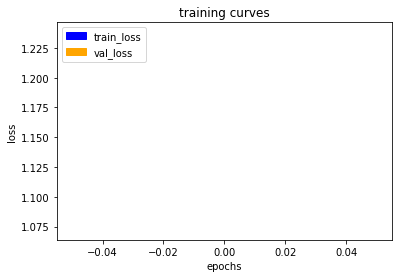

42/42 [==============================] - 66s - loss: 1.2368 - val_loss: 1.0722
Epoch 2/300
41/42 [============================>.] - ETA: 1s - loss: 1.1272

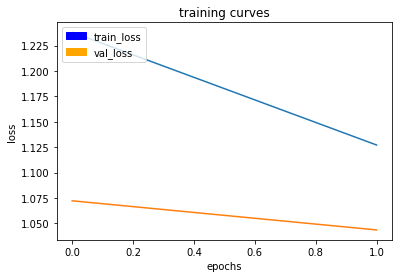

42/42 [==============================] - 62s - loss: 1.1270 - val_loss: 1.0435
Epoch 3/300
41/42 [============================>.] - ETA: 1s - loss: 1.0926

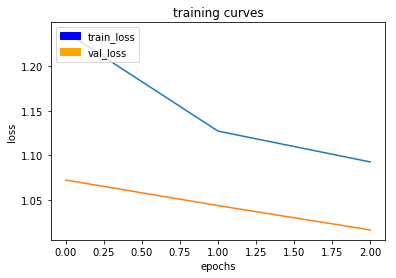

42/42 [==============================] - 62s - loss: 1.0924 - val_loss: 1.0162
Epoch 4/300
41/42 [============================>.] - ETA: 1s - loss: 1.0705

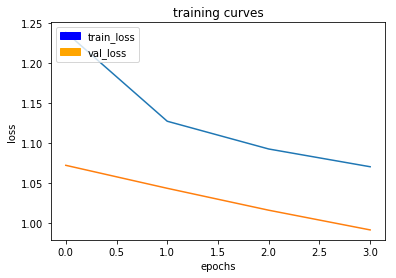

42/42 [==============================] - 61s - loss: 1.0702 - val_loss: 0.9916
Epoch 5/300
41/42 [============================>.] - ETA: 1s - loss: 1.0526

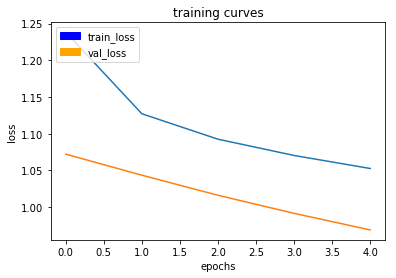

42/42 [==============================] - 62s - loss: 1.0527 - val_loss: 0.9690
Epoch 6/300
41/42 [============================>.] - ETA: 1s - loss: 1.0365

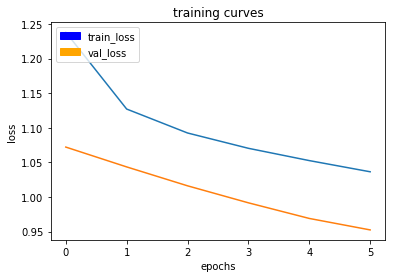

42/42 [==============================] - 62s - loss: 1.0364 - val_loss: 0.9524
Epoch 7/300
41/42 [============================>.] - ETA: 1s - loss: 1.0208

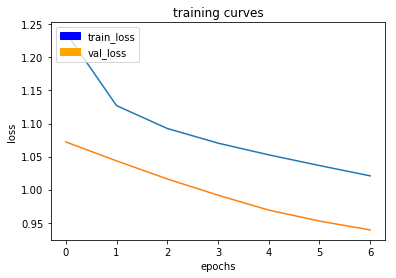

42/42 [==============================] - 62s - loss: 1.0208 - val_loss: 0.9390
Epoch 8/300
41/42 [============================>.] - ETA: 1s - loss: 1.0050

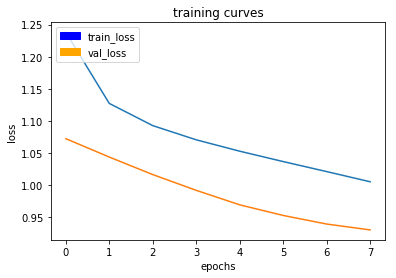

42/42 [==============================] - 62s - loss: 1.0048 - val_loss: 0.9299
Epoch 9/300
41/42 [============================>.] - ETA: 1s - loss: 0.9885

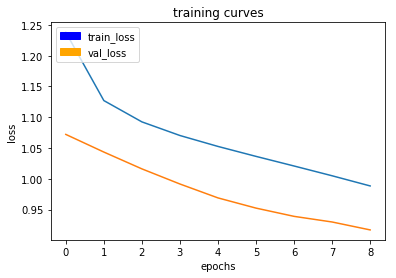

42/42 [==============================] - 61s - loss: 0.9883 - val_loss: 0.9170
Epoch 10/300
41/42 [============================>.] - ETA: 1s - loss: 0.9708

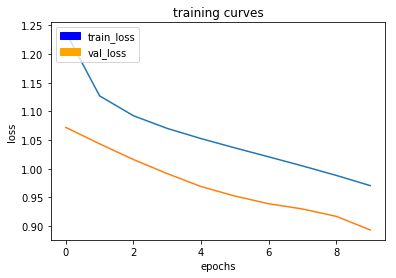

42/42 [==============================] - 62s - loss: 0.9704 - val_loss: 0.8934
Epoch 11/300
41/42 [============================>.] - ETA: 1s - loss: 0.9509

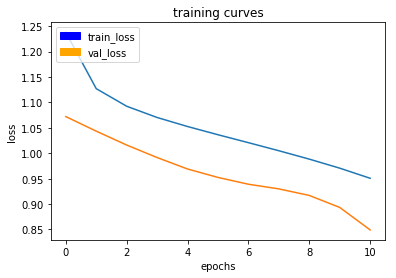

42/42 [==============================] - 62s - loss: 0.9505 - val_loss: 0.8491
Epoch 12/300
41/42 [============================>.] - ETA: 1s - loss: 0.9284

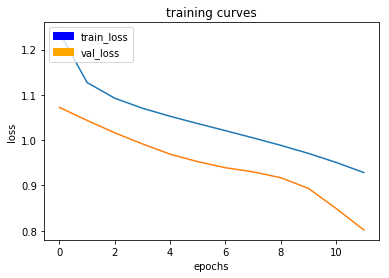

42/42 [==============================] - 61s - loss: 0.9285 - val_loss: 0.8017
Epoch 13/300
41/42 [============================>.] - ETA: 1s - loss: 0.9038

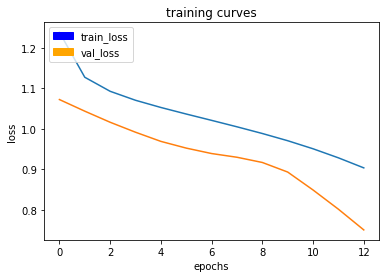

42/42 [==============================] - 62s - loss: 0.9034 - val_loss: 0.7507
Epoch 14/300
41/42 [============================>.] - ETA: 1s - loss: 0.8774

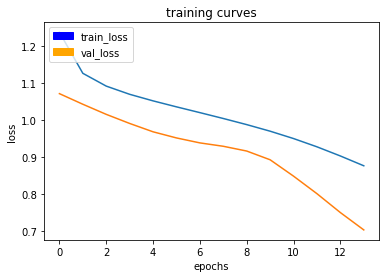

42/42 [==============================] - 61s - loss: 0.8766 - val_loss: 0.7038
Epoch 15/300
41/42 [============================>.] - ETA: 1s - loss: 0.8474

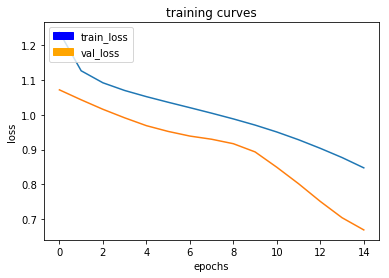

42/42 [==============================] - 61s - loss: 0.8475 - val_loss: 0.6686
Epoch 16/300
41/42 [============================>.] - ETA: 1s - loss: 0.8197

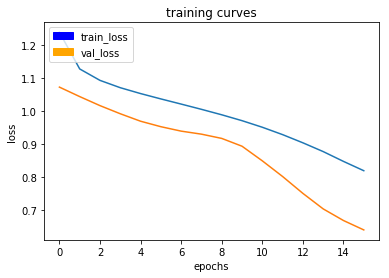

42/42 [==============================] - 62s - loss: 0.8186 - val_loss: 0.6402
Epoch 17/300
41/42 [============================>.] - ETA: 1s - loss: 0.7955

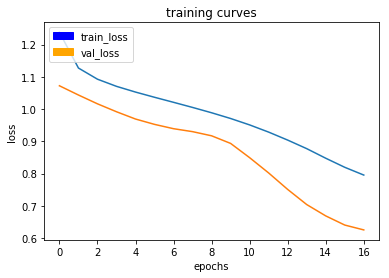

42/42 [==============================] - 62s - loss: 0.7947 - val_loss: 0.6252
Epoch 18/300
41/42 [============================>.] - ETA: 1s - loss: 0.7715

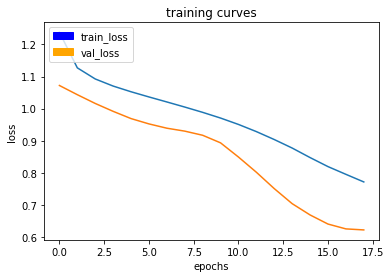

42/42 [==============================] - 62s - loss: 0.7715 - val_loss: 0.6220
Epoch 19/300
41/42 [============================>.] - ETA: 1s - loss: 0.7489

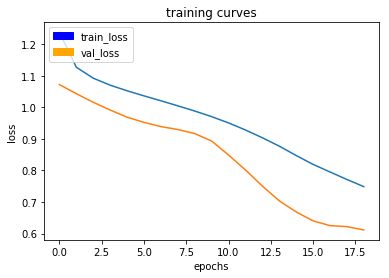

42/42 [==============================] - 62s - loss: 0.7485 - val_loss: 0.6115
Epoch 20/300
41/42 [============================>.] - ETA: 1s - loss: 0.7264

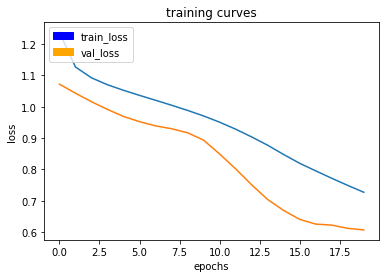

42/42 [==============================] - 62s - loss: 0.7278 - val_loss: 0.6066
Epoch 21/300
41/42 [============================>.] - ETA: 1s - loss: 0.7053

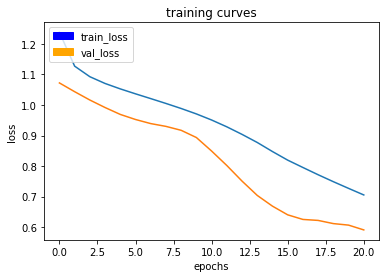

42/42 [==============================] - 62s - loss: 0.7054 - val_loss: 0.5908
Epoch 22/300
41/42 [============================>.] - ETA: 1s - loss: 0.6850

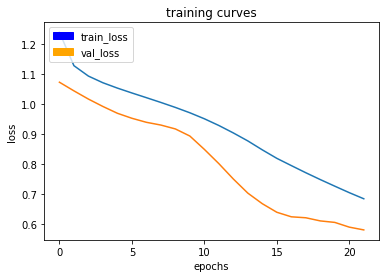

42/42 [==============================] - 62s - loss: 0.6852 - val_loss: 0.5816
Epoch 23/300
41/42 [============================>.] - ETA: 1s - loss: 0.6648

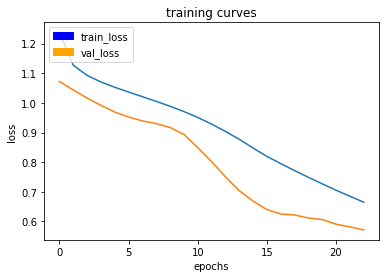

42/42 [==============================] - 62s - loss: 0.6649 - val_loss: 0.5715
Epoch 24/300
41/42 [============================>.] - ETA: 1s - loss: 0.6454

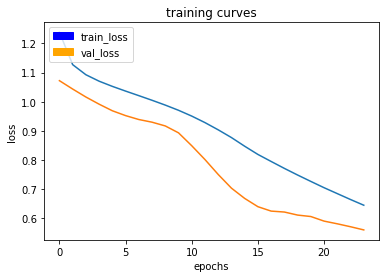

42/42 [==============================] - 62s - loss: 0.6450 - val_loss: 0.5607
Epoch 25/300
41/42 [============================>.] - ETA: 1s - loss: 0.6265

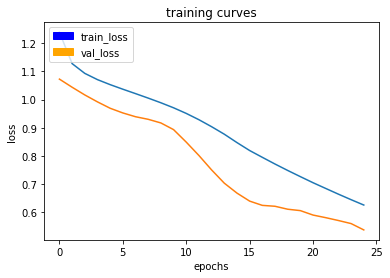

42/42 [==============================] - 61s - loss: 0.6260 - val_loss: 0.5382
Epoch 26/300
41/42 [============================>.] - ETA: 1s - loss: 0.6085

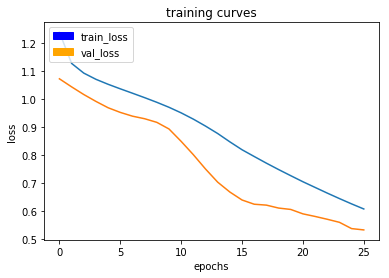

42/42 [==============================] - 62s - loss: 0.6077 - val_loss: 0.5336
Epoch 27/300
41/42 [============================>.] - ETA: 1s - loss: 0.5912

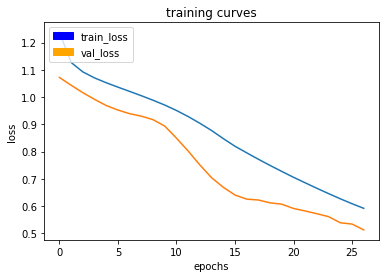

42/42 [==============================] - 62s - loss: 0.5917 - val_loss: 0.5121
Epoch 28/300
41/42 [============================>.] - ETA: 1s - loss: 0.5732

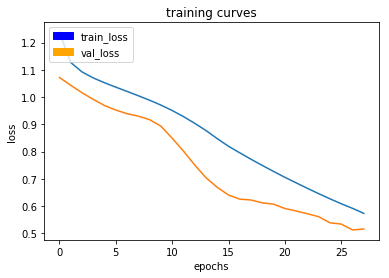

42/42 [==============================] - 62s - loss: 0.5725 - val_loss: 0.5153
Epoch 29/300
41/42 [============================>.] - ETA: 1s - loss: 0.5561

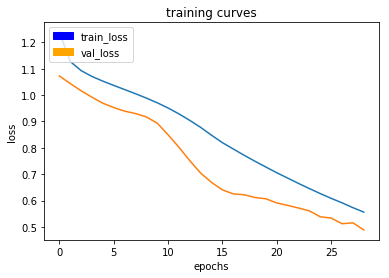

42/42 [==============================] - 62s - loss: 0.5562 - val_loss: 0.4886
Epoch 30/300
41/42 [============================>.] - ETA: 1s - loss: 0.5401

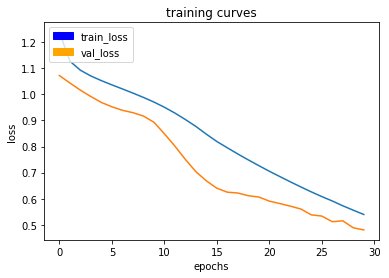

42/42 [==============================] - 62s - loss: 0.5390 - val_loss: 0.4805
Epoch 31/300
41/42 [============================>.] - ETA: 1s - loss: 0.5226

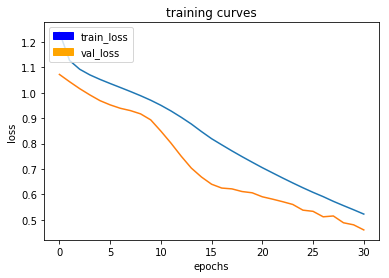

42/42 [==============================] - 62s - loss: 0.5231 - val_loss: 0.4605
Epoch 32/300
41/42 [============================>.] - ETA: 1s - loss: 0.5085

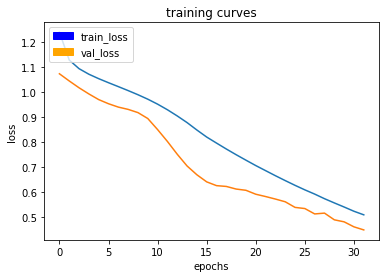

42/42 [==============================] - 61s - loss: 0.5084 - val_loss: 0.4482
Epoch 33/300
41/42 [============================>.] - ETA: 1s - loss: 0.4919

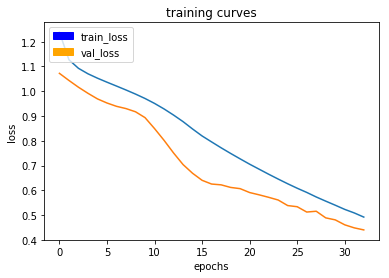

42/42 [==============================] - 62s - loss: 0.4914 - val_loss: 0.4399
Epoch 34/300
41/42 [============================>.] - ETA: 1s - loss: 0.4759

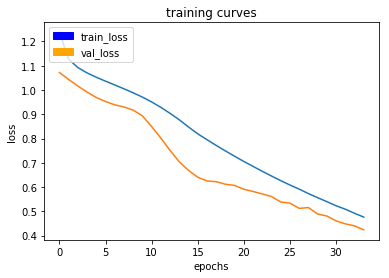

42/42 [==============================] - 61s - loss: 0.4762 - val_loss: 0.4232
Epoch 35/300
41/42 [============================>.] - ETA: 1s - loss: 0.4614

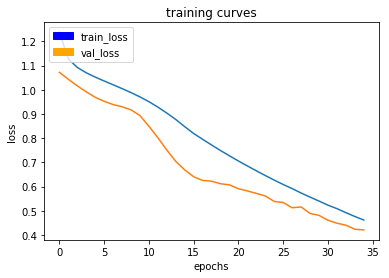

42/42 [==============================] - 61s - loss: 0.4611 - val_loss: 0.4204
Epoch 36/300
41/42 [============================>.] - ETA: 1s - loss: 0.4480

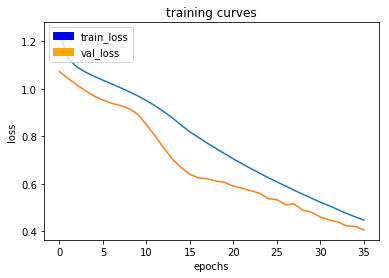

42/42 [==============================] - 62s - loss: 0.4474 - val_loss: 0.4062
Epoch 37/300
41/42 [============================>.] - ETA: 1s - loss: 0.4332

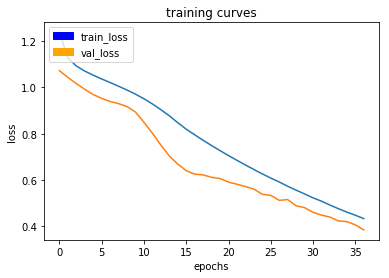

42/42 [==============================] - 61s - loss: 0.4333 - val_loss: 0.3844
Epoch 38/300
41/42 [============================>.] - ETA: 1s - loss: 0.4200

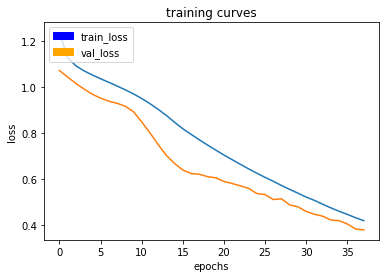

42/42 [==============================] - 62s - loss: 0.4211 - val_loss: 0.3803
Epoch 39/300
41/42 [============================>.] - ETA: 1s - loss: 0.4072

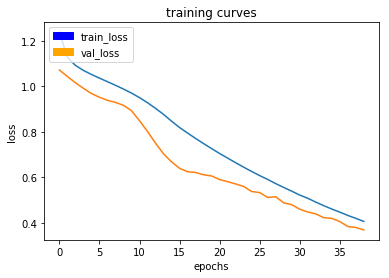

42/42 [==============================] - 62s - loss: 0.4064 - val_loss: 0.3695
Epoch 40/300
41/42 [============================>.] - ETA: 1s - loss: 0.3942

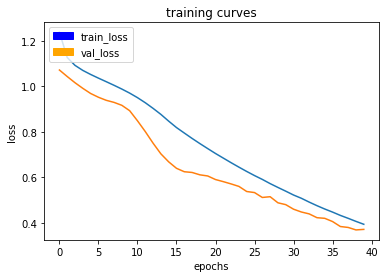

42/42 [==============================] - 62s - loss: 0.3941 - val_loss: 0.3718
Epoch 41/300
41/42 [============================>.] - ETA: 1s - loss: 0.3824

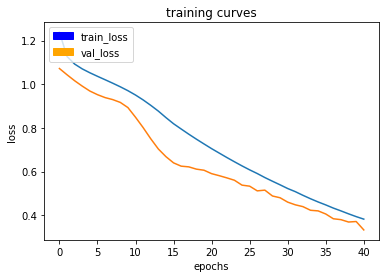

42/42 [==============================] - 62s - loss: 0.3831 - val_loss: 0.3333
Epoch 42/300
41/42 [============================>.] - ETA: 1s - loss: 0.3712

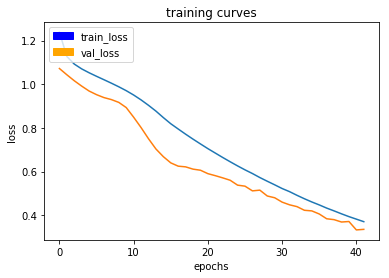

42/42 [==============================] - 62s - loss: 0.3706 - val_loss: 0.3359
Epoch 43/300
41/42 [============================>.] - ETA: 1s - loss: 0.3581

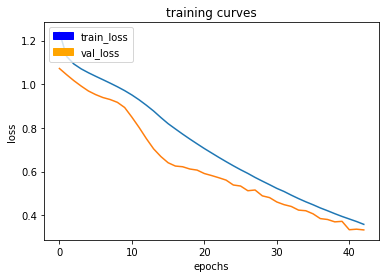

42/42 [==============================] - 61s - loss: 0.3578 - val_loss: 0.3325
Epoch 44/300
41/42 [============================>.] - ETA: 1s - loss: 0.3472

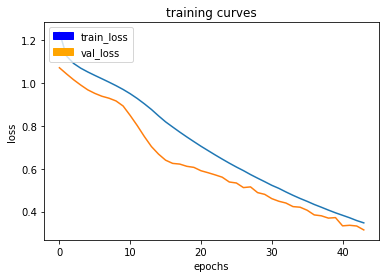

42/42 [==============================] - 61s - loss: 0.3471 - val_loss: 0.3143
Epoch 45/300
41/42 [============================>.] - ETA: 1s - loss: 0.3366

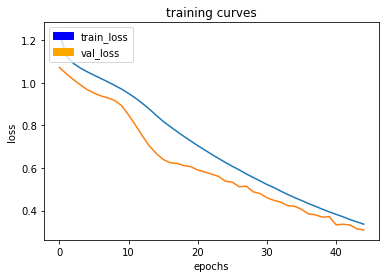

42/42 [==============================] - 62s - loss: 0.3359 - val_loss: 0.3094
Epoch 46/300
41/42 [============================>.] - ETA: 1s - loss: 0.3255

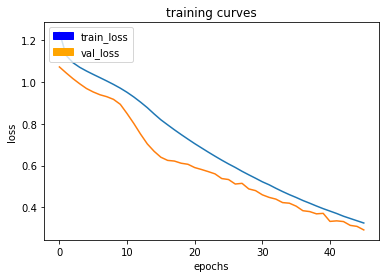

42/42 [==============================] - 61s - loss: 0.3257 - val_loss: 0.2926
Epoch 47/300
41/42 [============================>.] - ETA: 1s - loss: 0.3147

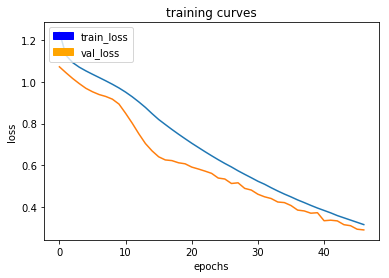

42/42 [==============================] - 61s - loss: 0.3147 - val_loss: 0.2892
Epoch 48/300
41/42 [============================>.] - ETA: 1s - loss: 0.3049

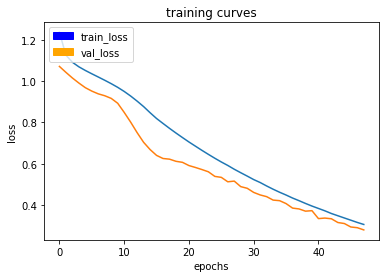

42/42 [==============================] - 62s - loss: 0.3048 - val_loss: 0.2784
Epoch 49/300
41/42 [============================>.] - ETA: 1s - loss: 0.2964

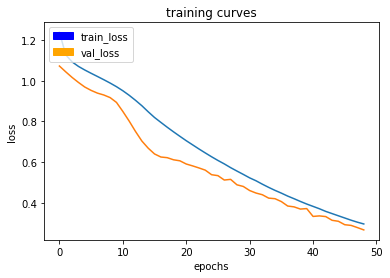

42/42 [==============================] - 62s - loss: 0.2959 - val_loss: 0.2670
Epoch 50/300
41/42 [============================>.] - ETA: 1s - loss: 0.2871

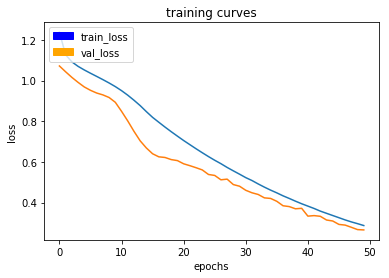

42/42 [==============================] - 61s - loss: 0.2869 - val_loss: 0.2655
Epoch 51/300
41/42 [============================>.] - ETA: 1s - loss: 0.2785

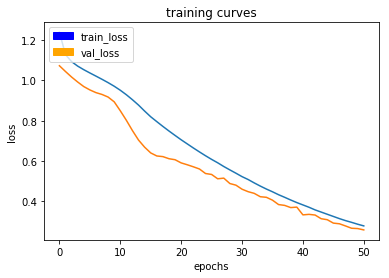

42/42 [==============================] - 62s - loss: 0.2792 - val_loss: 0.2588
Epoch 52/300
41/42 [============================>.] - ETA: 1s - loss: 0.2694

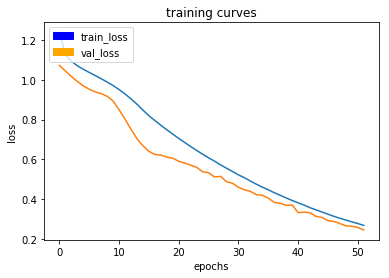

42/42 [==============================] - 62s - loss: 0.2689 - val_loss: 0.2466
Epoch 53/300
41/42 [============================>.] - ETA: 1s - loss: 0.2608

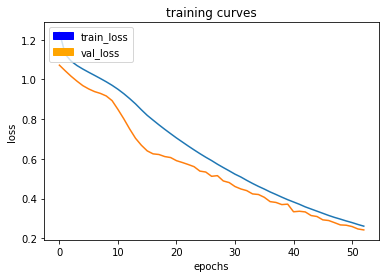

42/42 [==============================] - 62s - loss: 0.2606 - val_loss: 0.2418
Epoch 54/300
41/42 [============================>.] - ETA: 1s - loss: 0.2529

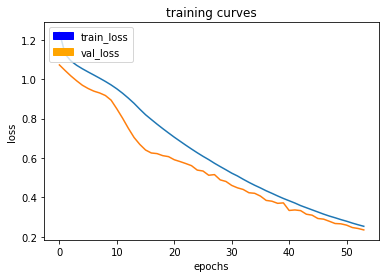

42/42 [==============================] - 62s - loss: 0.2528 - val_loss: 0.2345
Epoch 55/300
41/42 [============================>.] - ETA: 1s - loss: 0.2453

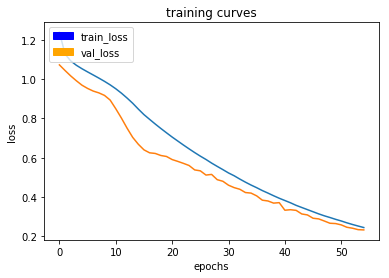

42/42 [==============================] - 61s - loss: 0.2451 - val_loss: 0.2332
Epoch 56/300
41/42 [============================>.] - ETA: 1s - loss: 0.2379

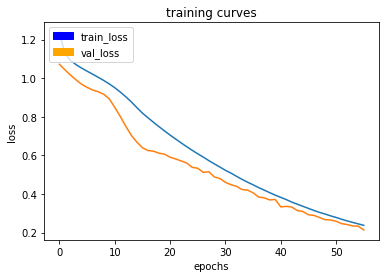

42/42 [==============================] - 62s - loss: 0.2378 - val_loss: 0.2140
Epoch 57/300
41/42 [============================>.] - ETA: 1s - loss: 0.2303

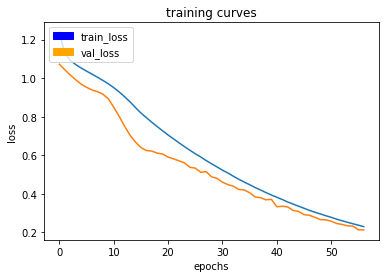

42/42 [==============================] - 62s - loss: 0.2305 - val_loss: 0.2133
Epoch 58/300
41/42 [============================>.] - ETA: 1s - loss: 0.2238

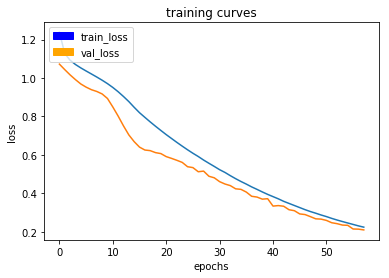

42/42 [==============================] - 61s - loss: 0.2232 - val_loss: 0.2093
Epoch 59/300
41/42 [============================>.] - ETA: 1s - loss: 0.2167

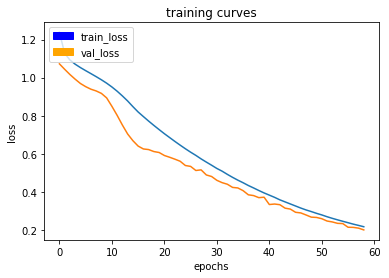

42/42 [==============================] - 62s - loss: 0.2166 - val_loss: 0.2000
Epoch 60/300
41/42 [============================>.] - ETA: 1s - loss: 0.2103

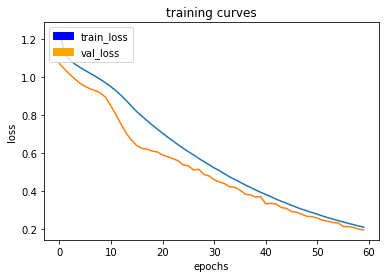

42/42 [==============================] - 62s - loss: 0.2102 - val_loss: 0.1958
Epoch 61/300
41/42 [============================>.] - ETA: 1s - loss: 0.2044

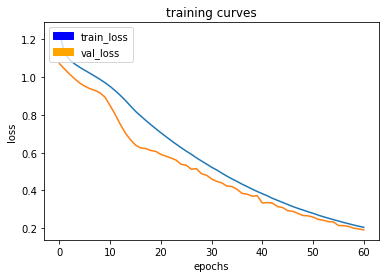

42/42 [==============================] - 61s - loss: 0.2045 - val_loss: 0.1907
Epoch 62/300
41/42 [============================>.] - ETA: 1s - loss: 0.1985

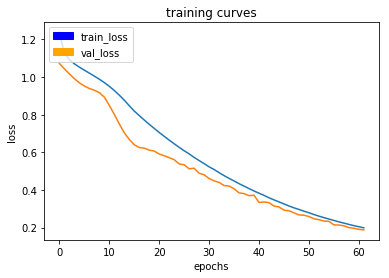

42/42 [==============================] - 62s - loss: 0.1987 - val_loss: 0.1874
Epoch 63/300
41/42 [============================>.] - ETA: 1s - loss: 0.1928

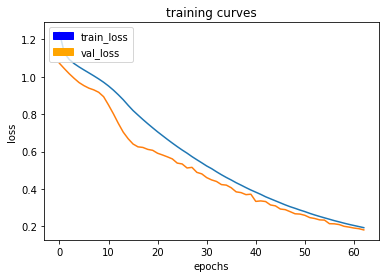

42/42 [==============================] - 62s - loss: 0.1928 - val_loss: 0.1807
Epoch 64/300
41/42 [============================>.] - ETA: 1s - loss: 0.1873

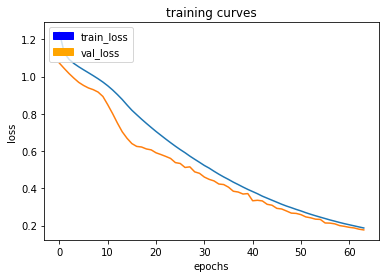

42/42 [==============================] - 61s - loss: 0.1868 - val_loss: 0.1768
Epoch 65/300
41/42 [============================>.] - ETA: 1s - loss: 0.1819

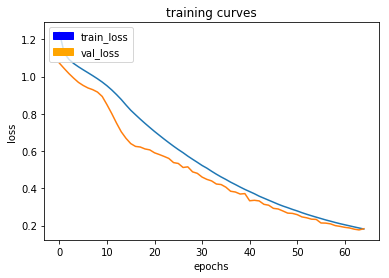

42/42 [==============================] - 62s - loss: 0.1811 - val_loss: 0.1831
Epoch 66/300
41/42 [============================>.] - ETA: 1s - loss: 0.1780

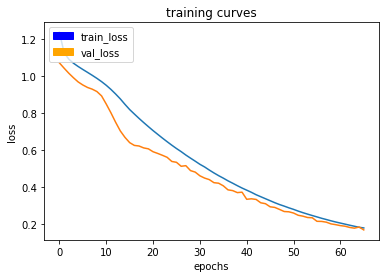

42/42 [==============================] - 61s - loss: 0.1781 - val_loss: 0.1674
Epoch 67/300
41/42 [============================>.] - ETA: 1s - loss: 0.1716

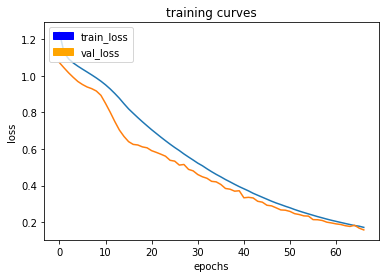

42/42 [==============================] - 62s - loss: 0.1717 - val_loss: 0.1577
Epoch 68/300
41/42 [============================>.] - ETA: 1s - loss: 0.1670

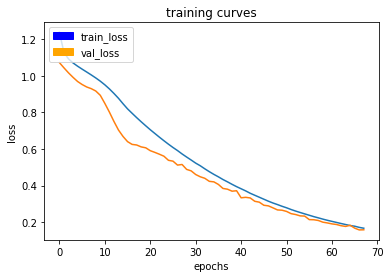

42/42 [==============================] - 62s - loss: 0.1671 - val_loss: 0.1585
Epoch 69/300
41/42 [============================>.] - ETA: 1s - loss: 0.1623

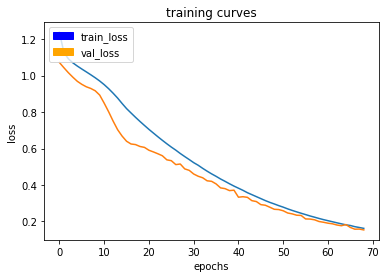

42/42 [==============================] - 61s - loss: 0.1624 - val_loss: 0.1538
Epoch 70/300
41/42 [============================>.] - ETA: 1s - loss: 0.1580

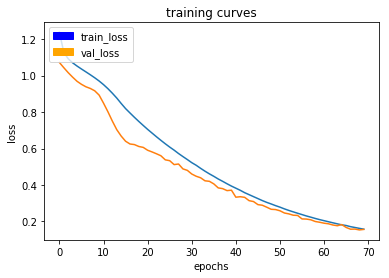

42/42 [==============================] - 62s - loss: 0.1581 - val_loss: 0.1566
Epoch 71/300
41/42 [============================>.] - ETA: 1s - loss: 0.1542

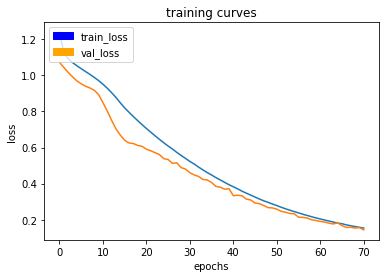

42/42 [==============================] - 62s - loss: 0.1543 - val_loss: 0.1438
Epoch 72/300
41/42 [============================>.] - ETA: 1s - loss: 0.1495

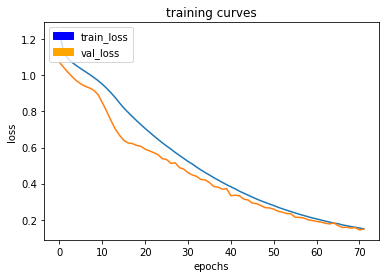

42/42 [==============================] - 62s - loss: 0.1498 - val_loss: 0.1480
Epoch 73/300
41/42 [============================>.] - ETA: 1s - loss: 0.1458

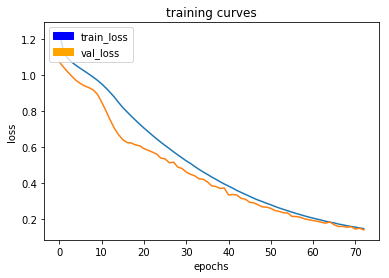

42/42 [==============================] - 62s - loss: 0.1462 - val_loss: 0.1389
Epoch 74/300
41/42 [============================>.] - ETA: 1s - loss: 0.1422

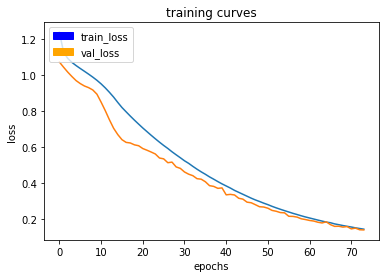

42/42 [==============================] - 61s - loss: 0.1424 - val_loss: 0.1381
Epoch 75/300
41/42 [============================>.] - ETA: 1s - loss: 0.1382

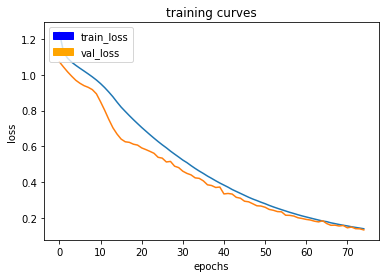

42/42 [==============================] - 62s - loss: 0.1386 - val_loss: 0.1319
Epoch 76/300
41/42 [============================>.] - ETA: 1s - loss: 0.1347

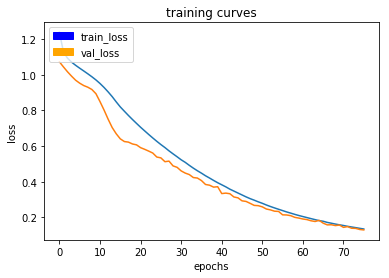

42/42 [==============================] - 61s - loss: 0.1346 - val_loss: 0.1295
Epoch 77/300
41/42 [============================>.] - ETA: 1s - loss: 0.1313

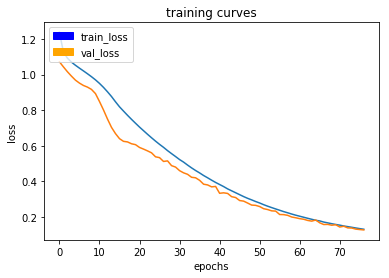

42/42 [==============================] - 62s - loss: 0.1311 - val_loss: 0.1275
Epoch 78/300
41/42 [============================>.] - ETA: 1s - loss: 0.1279

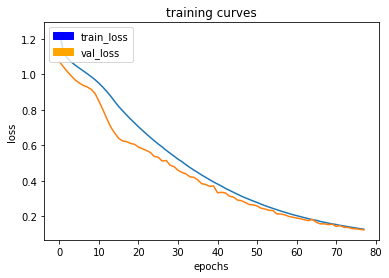

42/42 [==============================] - 62s - loss: 0.1278 - val_loss: 0.1239
Epoch 79/300
41/42 [============================>.] - ETA: 1s - loss: 0.1250

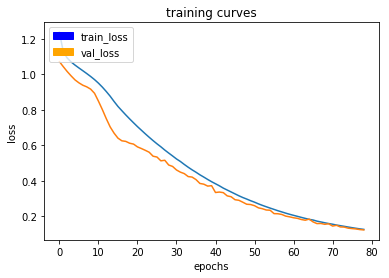

42/42 [==============================] - 61s - loss: 0.1251 - val_loss: 0.1221
Epoch 80/300
41/42 [============================>.] - ETA: 1s - loss: 0.1222

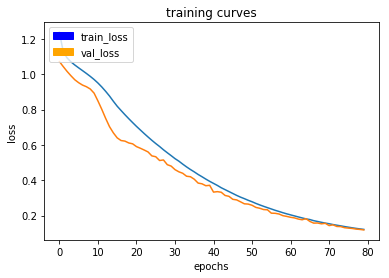

42/42 [==============================] - 61s - loss: 0.1222 - val_loss: 0.1193
Epoch 81/300
41/42 [============================>.] - ETA: 1s - loss: 0.1191

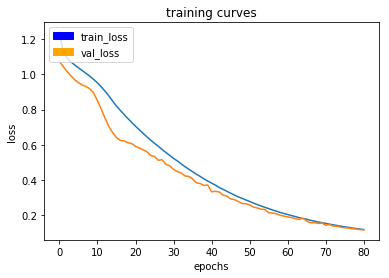

42/42 [==============================] - 62s - loss: 0.1191 - val_loss: 0.1172
Epoch 82/300
41/42 [============================>.] - ETA: 1s - loss: 0.1158

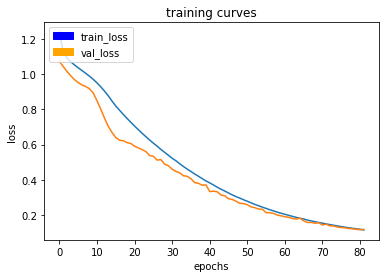

42/42 [==============================] - 62s - loss: 0.1157 - val_loss: 0.1187
Epoch 83/300
41/42 [============================>.] - ETA: 1s - loss: 0.1135

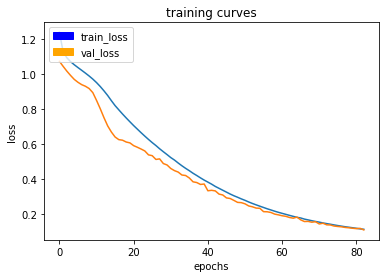

42/42 [==============================] - 62s - loss: 0.1136 - val_loss: 0.1098
Epoch 84/300
41/42 [============================>.] - ETA: 1s - loss: 0.1116

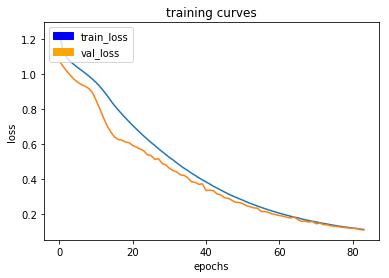

42/42 [==============================] - 61s - loss: 0.1115 - val_loss: 0.1087
Epoch 85/300
41/42 [============================>.] - ETA: 1s - loss: 0.1084

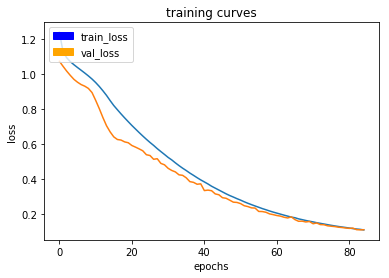

42/42 [==============================] - 62s - loss: 0.1083 - val_loss: 0.1095
Epoch 86/300
41/42 [============================>.] - ETA: 1s - loss: 0.1055

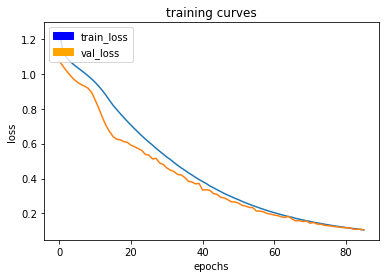

42/42 [==============================] - 62s - loss: 0.1056 - val_loss: 0.1061
Epoch 87/300
41/42 [============================>.] - ETA: 1s - loss: 0.1033

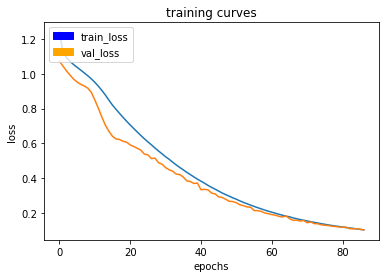

42/42 [==============================] - 62s - loss: 0.1033 - val_loss: 0.1026
Epoch 88/300
41/42 [============================>.] - ETA: 1s - loss: 0.1012

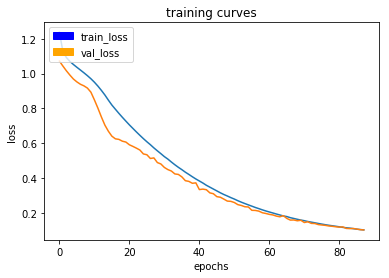

42/42 [==============================] - 62s - loss: 0.1018 - val_loss: 0.1012
Epoch 89/300
41/42 [============================>.] - ETA: 1s - loss: 0.0997

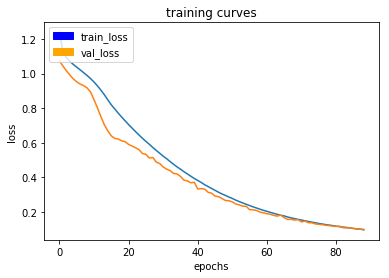

42/42 [==============================] - 62s - loss: 0.0996 - val_loss: 0.0973
Epoch 90/300
41/42 [============================>.] - ETA: 1s - loss: 0.0967

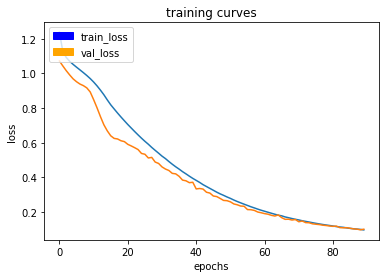

42/42 [==============================] - 62s - loss: 0.0966 - val_loss: 0.1008
Epoch 91/300
41/42 [============================>.] - ETA: 1s - loss: 0.0948

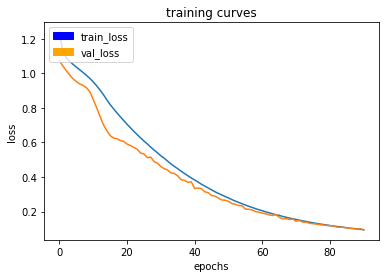

42/42 [==============================] - 62s - loss: 0.0948 - val_loss: 0.0936
Epoch 92/300
41/42 [============================>.] - ETA: 1s - loss: 0.0928

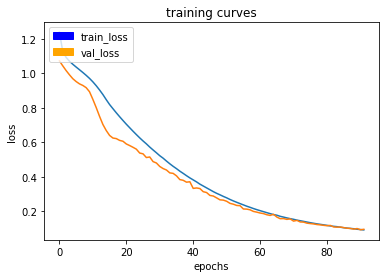

42/42 [==============================] - 62s - loss: 0.0927 - val_loss: 0.0964
Epoch 93/300
41/42 [============================>.] - ETA: 1s - loss: 0.0908

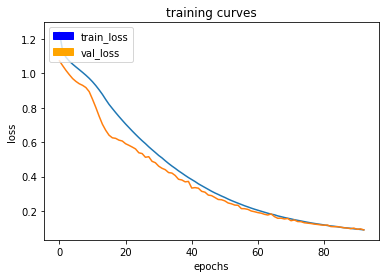

42/42 [==============================] - 61s - loss: 0.0906 - val_loss: 0.0902
Epoch 94/300
41/42 [============================>.] - ETA: 1s - loss: 0.0889

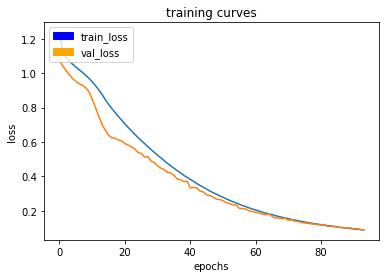

42/42 [==============================] - 61s - loss: 0.0886 - val_loss: 0.0900
Epoch 95/300
41/42 [============================>.] - ETA: 1s - loss: 0.0870

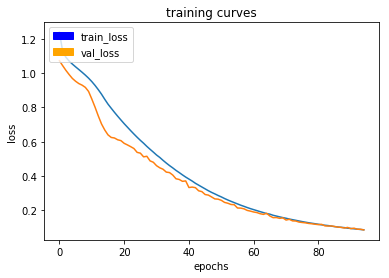

42/42 [==============================] - 62s - loss: 0.0870 - val_loss: 0.0863
Epoch 96/300
41/42 [============================>.] - ETA: 1s - loss: 0.0860

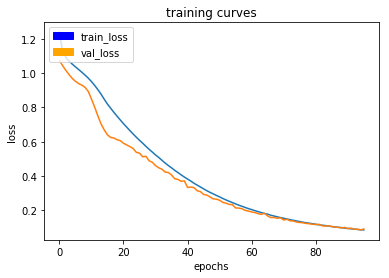

42/42 [==============================] - 62s - loss: 0.0861 - val_loss: 0.0914
Epoch 97/300
41/42 [============================>.] - ETA: 1s - loss: 0.0836

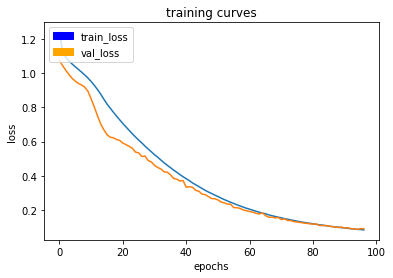

42/42 [==============================] - 61s - loss: 0.0836 - val_loss: 0.0908
Epoch 98/300
41/42 [============================>.] - ETA: 1s - loss: 0.0820

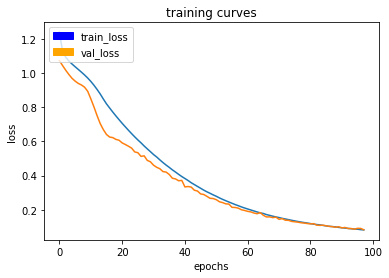

42/42 [==============================] - 61s - loss: 0.0820 - val_loss: 0.0828
Epoch 99/300
41/42 [============================>.] - ETA: 1s - loss: 0.0808

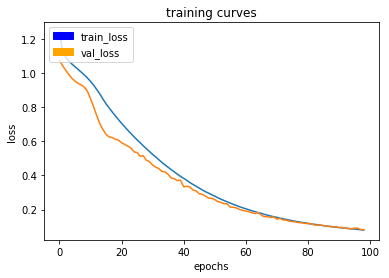

42/42 [==============================] - 62s - loss: 0.0807 - val_loss: 0.0823
Epoch 100/300
41/42 [============================>.] - ETA: 1s - loss: 0.0792

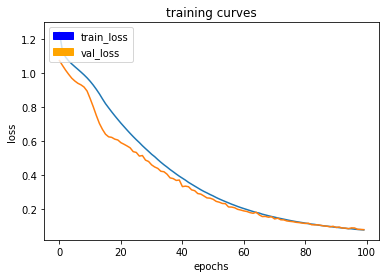

42/42 [==============================] - 62s - loss: 0.0798 - val_loss: 0.0810
Epoch 101/300
41/42 [============================>.] - ETA: 1s - loss: 0.0775

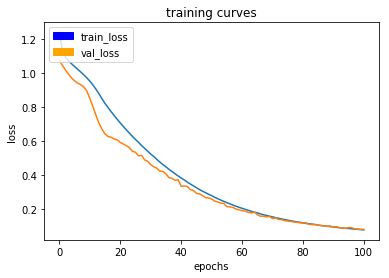

42/42 [==============================] - 62s - loss: 0.0774 - val_loss: 0.0810
Epoch 102/300
41/42 [============================>.] - ETA: 1s - loss: 0.0760

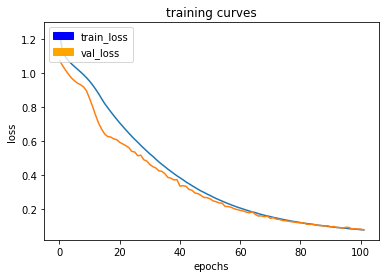

42/42 [==============================] - 62s - loss: 0.0761 - val_loss: 0.0760
Epoch 103/300
41/42 [============================>.] - ETA: 1s - loss: 0.0748

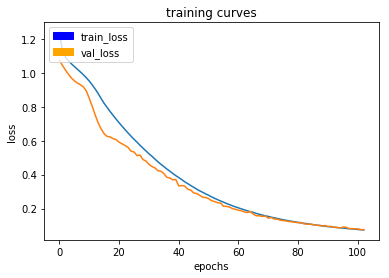

42/42 [==============================] - 61s - loss: 0.0747 - val_loss: 0.0769
Epoch 104/300
41/42 [============================>.] - ETA: 1s - loss: 0.0738

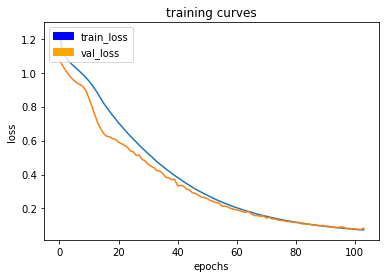

42/42 [==============================] - 62s - loss: 0.0738 - val_loss: 0.0840
Epoch 105/300
41/42 [============================>.] - ETA: 1s - loss: 0.0721

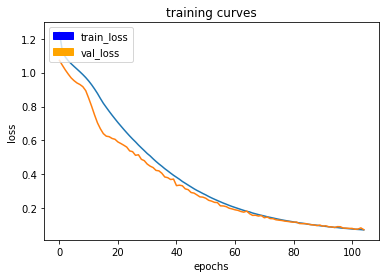

42/42 [==============================] - 62s - loss: 0.0718 - val_loss: 0.0735
Epoch 106/300
41/42 [============================>.] - ETA: 1s - loss: 0.0709

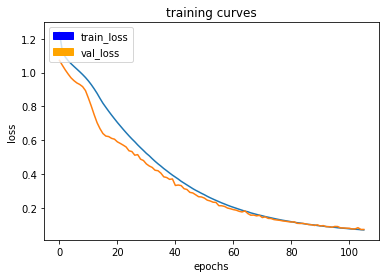

42/42 [==============================] - 61s - loss: 0.0707 - val_loss: 0.0735
Epoch 107/300
41/42 [============================>.] - ETA: 1s - loss: 0.0698

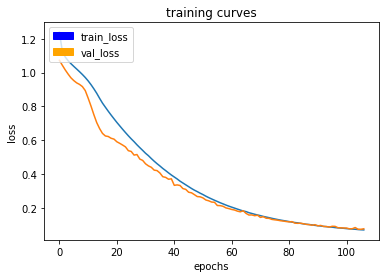

42/42 [==============================] - 62s - loss: 0.0699 - val_loss: 0.0765
Epoch 108/300
41/42 [============================>.] - ETA: 1s - loss: 0.0685

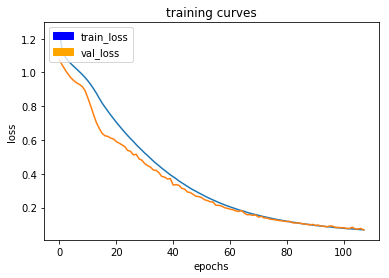

42/42 [==============================] - 61s - loss: 0.0686 - val_loss: 0.0679
Epoch 109/300
41/42 [============================>.] - ETA: 1s - loss: 0.0671

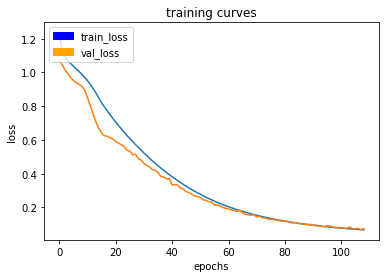

42/42 [==============================] - 62s - loss: 0.0671 - val_loss: 0.0744
Epoch 110/300
41/42 [============================>.] - ETA: 1s - loss: 0.0662

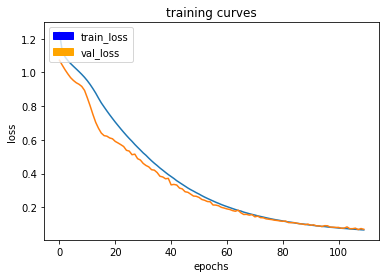

42/42 [==============================] - 61s - loss: 0.0661 - val_loss: 0.0698
Epoch 111/300
41/42 [============================>.] - ETA: 1s - loss: 0.0653

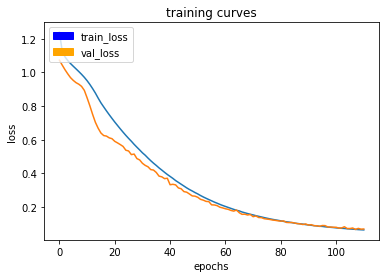

42/42 [==============================] - 62s - loss: 0.0652 - val_loss: 0.0707
Epoch 112/300
41/42 [============================>.] - ETA: 1s - loss: 0.0641

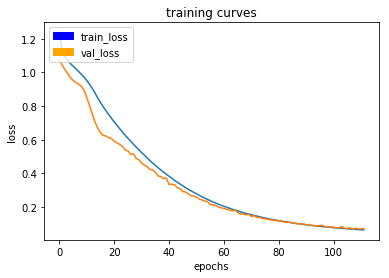

42/42 [==============================] - 62s - loss: 0.0642 - val_loss: 0.0715
Epoch 113/300
41/42 [============================>.] - ETA: 1s - loss: 0.0631

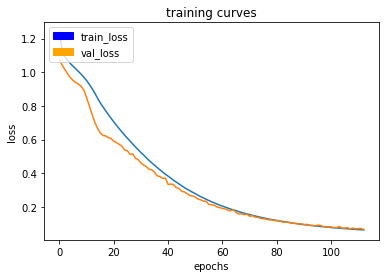

42/42 [==============================] - 62s - loss: 0.0630 - val_loss: 0.0656
Epoch 114/300
41/42 [============================>.] - ETA: 1s - loss: 0.0619

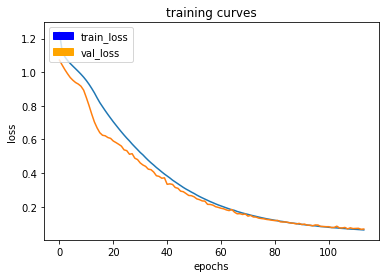

42/42 [==============================] - 61s - loss: 0.0618 - val_loss: 0.0673
Epoch 115/300
41/42 [============================>.] - ETA: 1s - loss: 0.0610

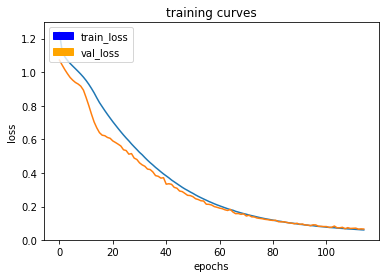

42/42 [==============================] - 62s - loss: 0.0609 - val_loss: 0.0662
Epoch 116/300
41/42 [============================>.] - ETA: 1s - loss: 0.0601

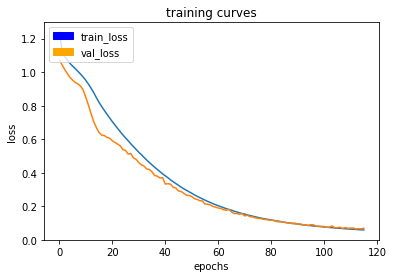

42/42 [==============================] - 62s - loss: 0.0602 - val_loss: 0.0701
Epoch 117/300
41/42 [============================>.] - ETA: 1s - loss: 0.0594

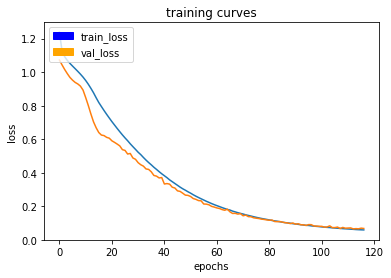

42/42 [==============================] - 62s - loss: 0.0599 - val_loss: 0.0682
Epoch 118/300
41/42 [============================>.] - ETA: 1s - loss: 0.0585

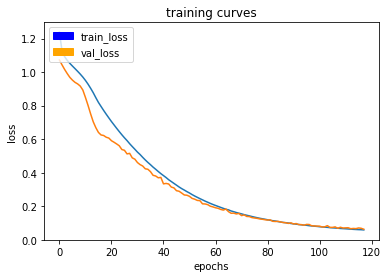

42/42 [==============================] - 61s - loss: 0.0584 - val_loss: 0.0625
Epoch 119/300
41/42 [============================>.] - ETA: 1s - loss: 0.0576

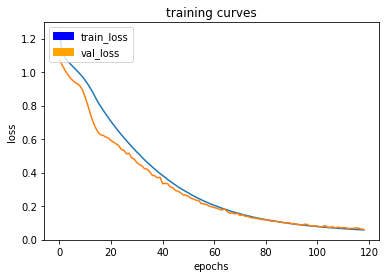

42/42 [==============================] - 61s - loss: 0.0576 - val_loss: 0.0607
Epoch 120/300
41/42 [============================>.] - ETA: 1s - loss: 0.0566

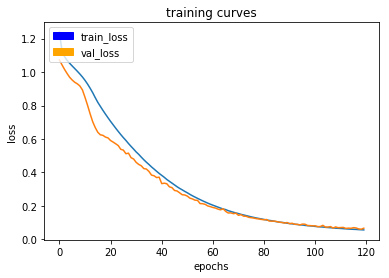

42/42 [==============================] - 61s - loss: 0.0566 - val_loss: 0.0669
Epoch 121/300
41/42 [============================>.] - ETA: 1s - loss: 0.0559

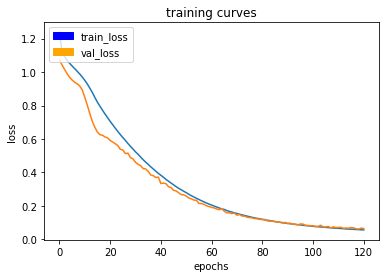

42/42 [==============================] - 62s - loss: 0.0557 - val_loss: 0.0638
Epoch 122/300
41/42 [============================>.] - ETA: 1s - loss: 0.0551

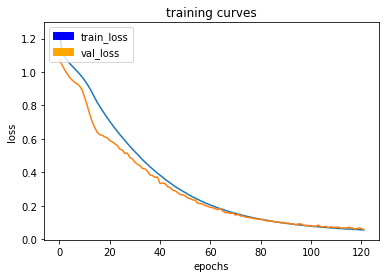

42/42 [==============================] - 62s - loss: 0.0551 - val_loss: 0.0555
Epoch 123/300
41/42 [============================>.] - ETA: 1s - loss: 0.0542

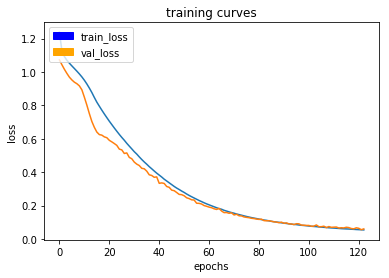

42/42 [==============================] - 61s - loss: 0.0542 - val_loss: 0.0603
Epoch 124/300
41/42 [============================>.] - ETA: 1s - loss: 0.0536

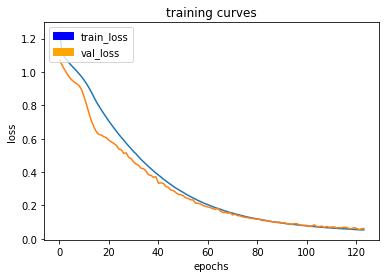

42/42 [==============================] - 61s - loss: 0.0536 - val_loss: 0.0623
Epoch 125/300
41/42 [============================>.] - ETA: 1s - loss: 0.0529

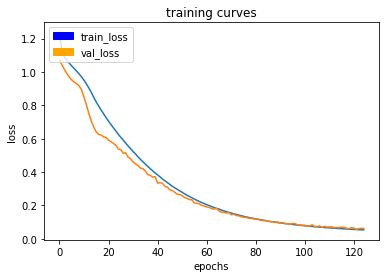

42/42 [==============================] - 61s - loss: 0.0528 - val_loss: 0.0620
Epoch 126/300
41/42 [============================>.] - ETA: 1s - loss: 0.0524

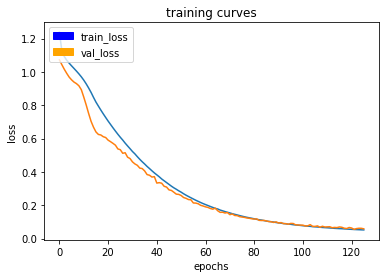

42/42 [==============================] - 61s - loss: 0.0523 - val_loss: 0.0590
Epoch 127/300
41/42 [============================>.] - ETA: 1s - loss: 0.0516

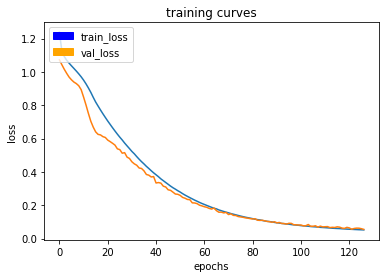

42/42 [==============================] - 61s - loss: 0.0517 - val_loss: 0.0548
Epoch 128/300
41/42 [============================>.] - ETA: 1s - loss: 0.0510

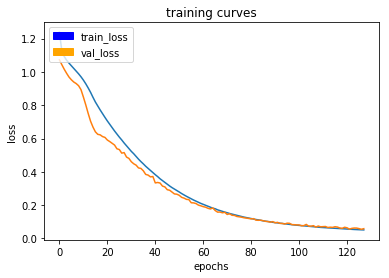

42/42 [==============================] - 62s - loss: 0.0510 - val_loss: 0.0585
Epoch 129/300
41/42 [============================>.] - ETA: 1s - loss: 0.0504

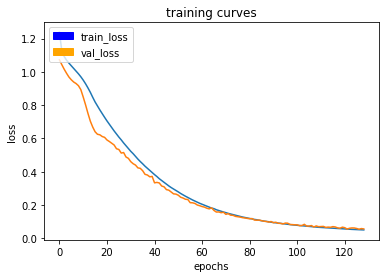

42/42 [==============================] - 61s - loss: 0.0504 - val_loss: 0.0563
Epoch 130/300
41/42 [============================>.] - ETA: 1s - loss: 0.0497

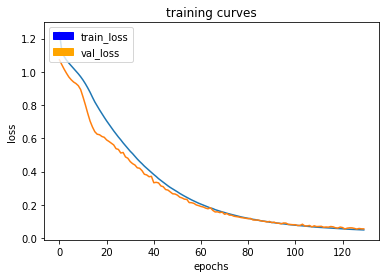

42/42 [==============================] - 61s - loss: 0.0499 - val_loss: 0.0561
Epoch 131/300
41/42 [============================>.] - ETA: 1s - loss: 0.0489

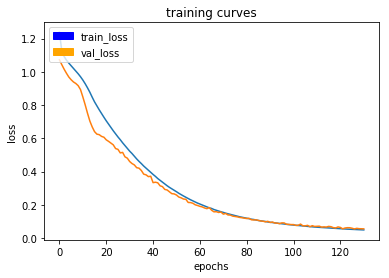

42/42 [==============================] - 62s - loss: 0.0489 - val_loss: 0.0553
Epoch 132/300
41/42 [============================>.] - ETA: 1s - loss: 0.0483

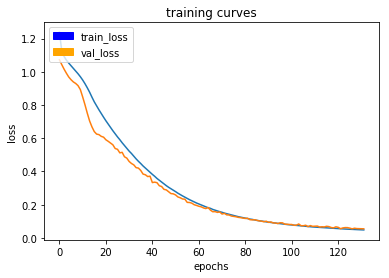

42/42 [==============================] - 62s - loss: 0.0482 - val_loss: 0.0549
Epoch 133/300
41/42 [============================>.] - ETA: 1s - loss: 0.0478

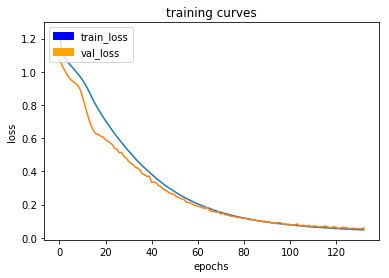

42/42 [==============================] - 62s - loss: 0.0477 - val_loss: 0.0594
Epoch 134/300
41/42 [============================>.] - ETA: 1s - loss: 0.0471

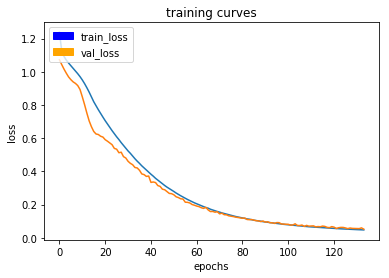

42/42 [==============================] - 62s - loss: 0.0471 - val_loss: 0.0515
Epoch 135/300
41/42 [============================>.] - ETA: 1s - loss: 0.0468

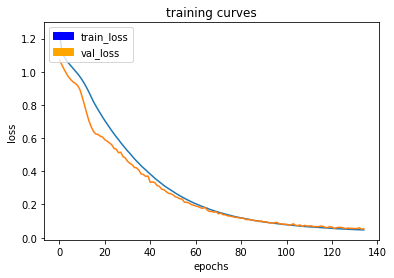

42/42 [==============================] - 61s - loss: 0.0469 - val_loss: 0.0537
Epoch 136/300
41/42 [============================>.] - ETA: 1s - loss: 0.0463

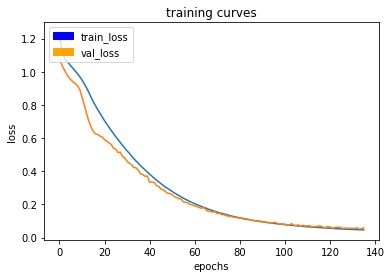

42/42 [==============================] - 62s - loss: 0.0462 - val_loss: 0.0588
Epoch 137/300
41/42 [============================>.] - ETA: 1s - loss: 0.0456

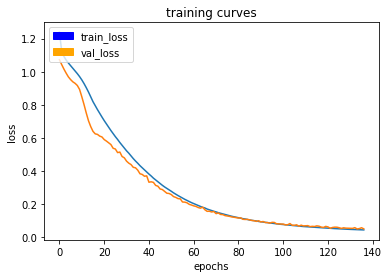

42/42 [==============================] - 61s - loss: 0.0457 - val_loss: 0.0519
Epoch 138/300
41/42 [============================>.] - ETA: 1s - loss: 0.0452

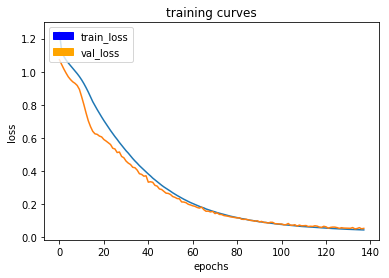

42/42 [==============================] - 62s - loss: 0.0450 - val_loss: 0.0544
Epoch 139/300
41/42 [============================>.] - ETA: 1s - loss: 0.0445

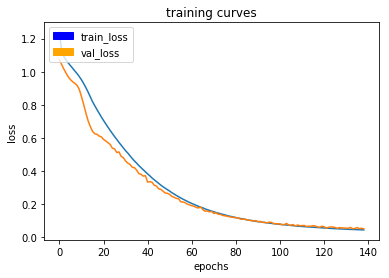

42/42 [==============================] - 61s - loss: 0.0445 - val_loss: 0.0516
Epoch 140/300
41/42 [============================>.] - ETA: 1s - loss: 0.0439

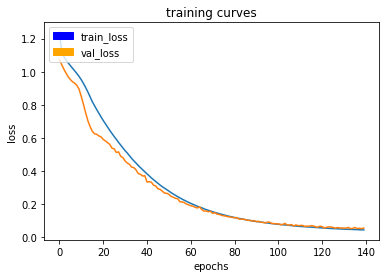

42/42 [==============================] - 62s - loss: 0.0446 - val_loss: 0.0556
Epoch 141/300
41/42 [============================>.] - ETA: 1s - loss: 0.0435

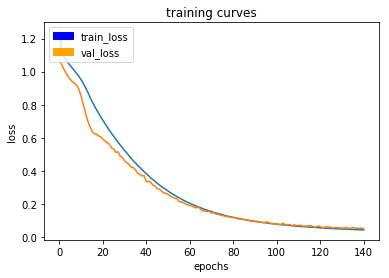

42/42 [==============================] - 61s - loss: 0.0435 - val_loss: 0.0492
Epoch 142/300
41/42 [============================>.] - ETA: 1s - loss: 0.0434

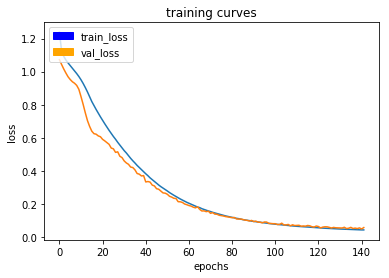

42/42 [==============================] - 61s - loss: 0.0434 - val_loss: 0.0575
Epoch 143/300
41/42 [============================>.] - ETA: 1s - loss: 0.0426

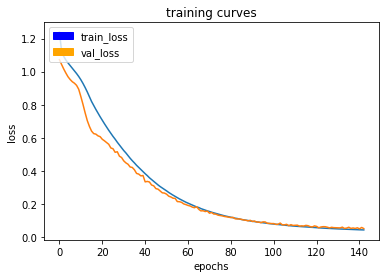

42/42 [==============================] - 62s - loss: 0.0428 - val_loss: 0.0509
Epoch 144/300
41/42 [============================>.] - ETA: 1s - loss: 0.0423

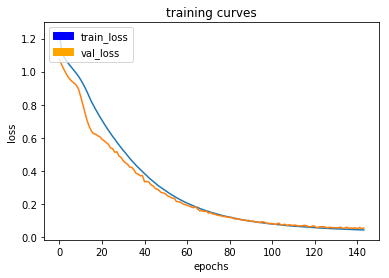

42/42 [==============================] - 62s - loss: 0.0423 - val_loss: 0.0536
Epoch 145/300
41/42 [============================>.] - ETA: 1s - loss: 0.0419

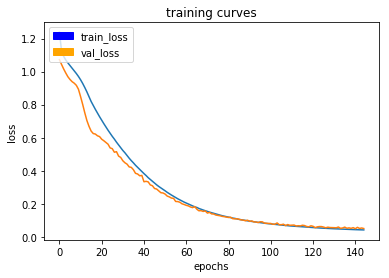

42/42 [==============================] - 62s - loss: 0.0419 - val_loss: 0.0503
Epoch 146/300
41/42 [============================>.] - ETA: 1s - loss: 0.0416

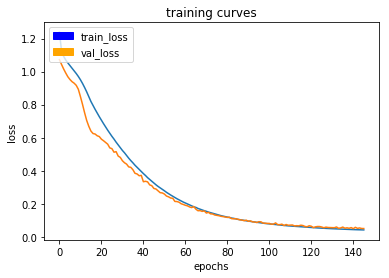

42/42 [==============================] - 62s - loss: 0.0416 - val_loss: 0.0500
Epoch 147/300
41/42 [============================>.] - ETA: 1s - loss: 0.0410

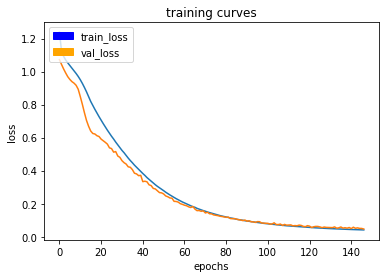

42/42 [==============================] - 62s - loss: 0.0410 - val_loss: 0.0464
Epoch 148/300
41/42 [============================>.] - ETA: 1s - loss: 0.0407

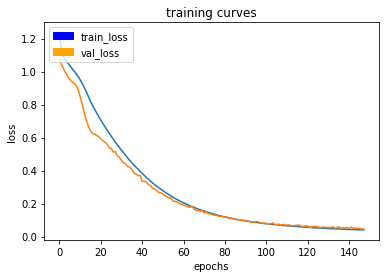

42/42 [==============================] - 62s - loss: 0.0406 - val_loss: 0.0460
Epoch 149/300
41/42 [============================>.] - ETA: 1s - loss: 0.0403

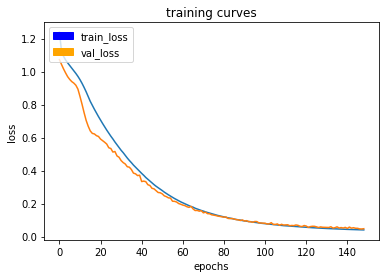

42/42 [==============================] - 61s - loss: 0.0402 - val_loss: 0.0476
Epoch 150/300
41/42 [============================>.] - ETA: 1s - loss: 0.0399

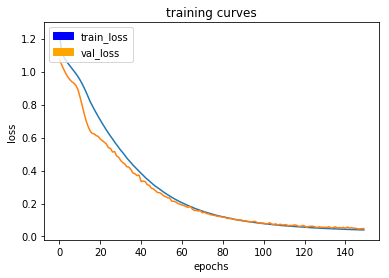

42/42 [==============================] - 62s - loss: 0.0398 - val_loss: 0.0480
Epoch 151/300
41/42 [============================>.] - ETA: 1s - loss: 0.0395

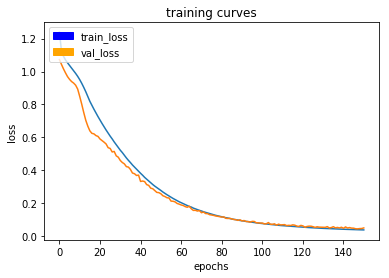

42/42 [==============================] - 62s - loss: 0.0394 - val_loss: 0.0515
Epoch 152/300
41/42 [============================>.] - ETA: 1s - loss: 0.0390

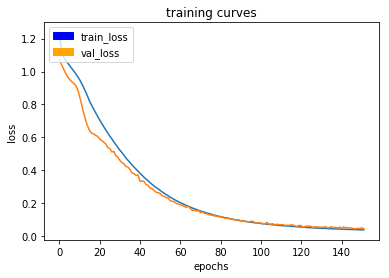

42/42 [==============================] - 62s - loss: 0.0390 - val_loss: 0.0464
Epoch 153/300
41/42 [============================>.] - ETA: 1s - loss: 0.0391

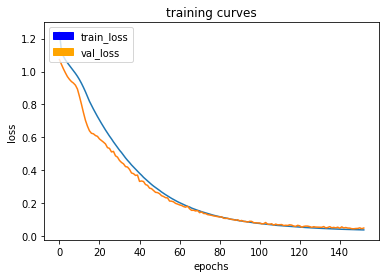

42/42 [==============================] - 62s - loss: 0.0390 - val_loss: 0.0505
Epoch 154/300
41/42 [============================>.] - ETA: 1s - loss: 0.0386

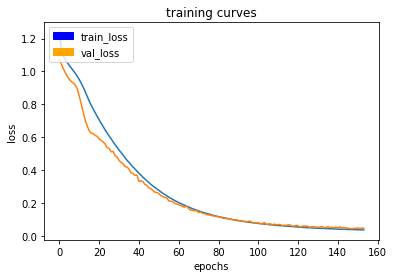

42/42 [==============================] - 62s - loss: 0.0385 - val_loss: 0.0486
Epoch 155/300
41/42 [============================>.] - ETA: 1s - loss: 0.0381

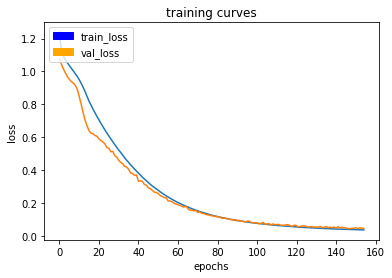

42/42 [==============================] - 62s - loss: 0.0380 - val_loss: 0.0472
Epoch 156/300
41/42 [============================>.] - ETA: 1s - loss: 0.0379

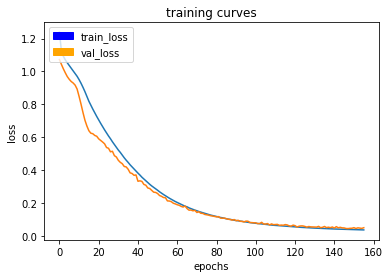

42/42 [==============================] - 62s - loss: 0.0378 - val_loss: 0.0512
Epoch 157/300
41/42 [============================>.] - ETA: 1s - loss: 0.0380

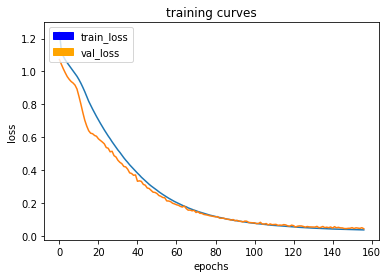

42/42 [==============================] - 61s - loss: 0.0380 - val_loss: 0.0452
Epoch 158/300
41/42 [============================>.] - ETA: 1s - loss: 0.0372

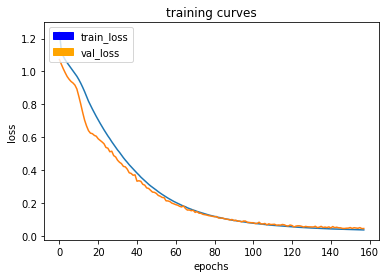

42/42 [==============================] - 62s - loss: 0.0372 - val_loss: 0.0458
Epoch 159/300
41/42 [============================>.] - ETA: 1s - loss: 0.0366

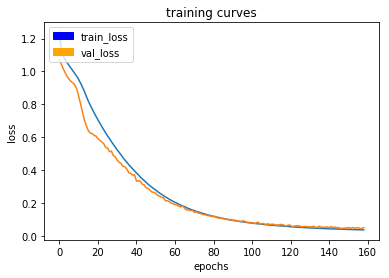

42/42 [==============================] - 61s - loss: 0.0366 - val_loss: 0.0509
Epoch 160/300
41/42 [============================>.] - ETA: 1s - loss: 0.0369

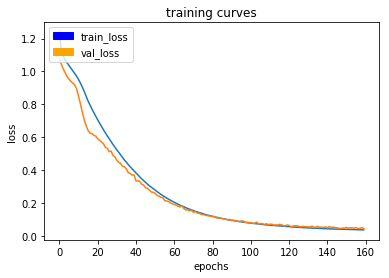

42/42 [==============================] - 62s - loss: 0.0368 - val_loss: 0.0439
Epoch 161/300
41/42 [============================>.] - ETA: 1s - loss: 0.0364

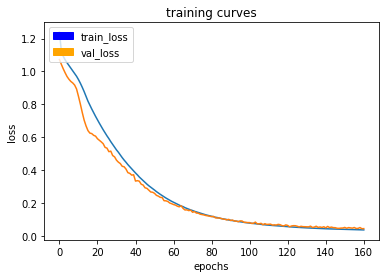

42/42 [==============================] - 61s - loss: 0.0367 - val_loss: 0.0443
Epoch 162/300
41/42 [============================>.] - ETA: 1s - loss: 0.0360

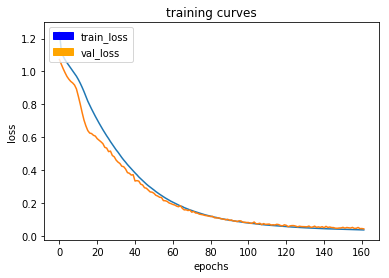

42/42 [==============================] - 62s - loss: 0.0359 - val_loss: 0.0423
Epoch 163/300
41/42 [============================>.] - ETA: 1s - loss: 0.0357

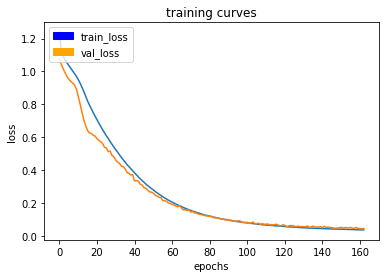

42/42 [==============================] - 62s - loss: 0.0356 - val_loss: 0.0453
Epoch 164/300
41/42 [============================>.] - ETA: 1s - loss: 0.0358

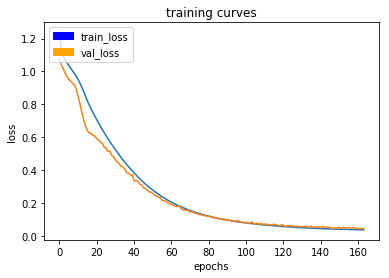

42/42 [==============================] - 62s - loss: 0.0357 - val_loss: 0.0433
Epoch 165/300
41/42 [============================>.] - ETA: 1s - loss: 0.0354

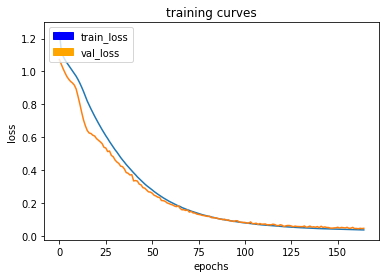

42/42 [==============================] - 62s - loss: 0.0354 - val_loss: 0.0450
Epoch 166/300
41/42 [============================>.] - ETA: 1s - loss: 0.0349

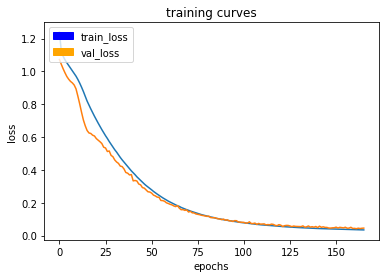

42/42 [==============================] - 62s - loss: 0.0347 - val_loss: 0.0457
Epoch 167/300
41/42 [============================>.] - ETA: 1s - loss: 0.0349

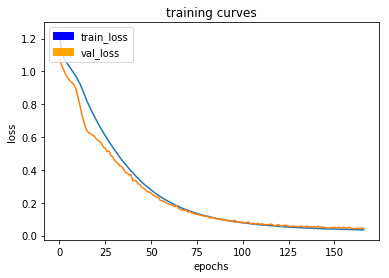

42/42 [==============================] - 61s - loss: 0.0348 - val_loss: 0.0431
Epoch 168/300
41/42 [============================>.] - ETA: 1s - loss: 0.0343

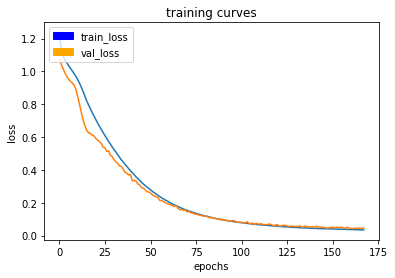

42/42 [==============================] - 62s - loss: 0.0343 - val_loss: 0.0468
Epoch 169/300
41/42 [============================>.] - ETA: 1s - loss: 0.0341

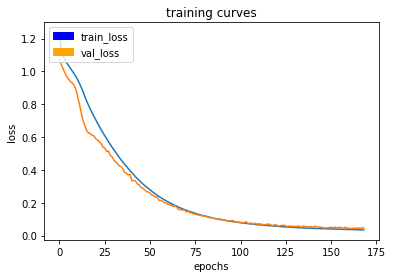

42/42 [==============================] - 62s - loss: 0.0342 - val_loss: 0.0452
Epoch 170/300
41/42 [============================>.] - ETA: 1s - loss: 0.0339

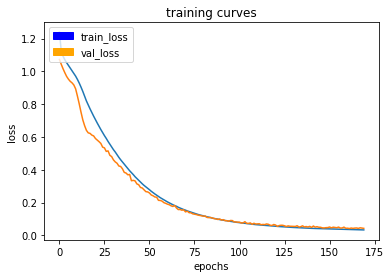

42/42 [==============================] - 62s - loss: 0.0338 - val_loss: 0.0434
Epoch 171/300
41/42 [============================>.] - ETA: 1s - loss: 0.0337

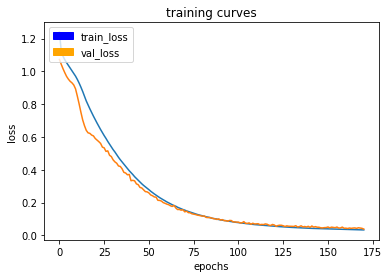

42/42 [==============================] - 61s - loss: 0.0336 - val_loss: 0.0387
Epoch 172/300
41/42 [============================>.] - ETA: 1s - loss: 0.0334

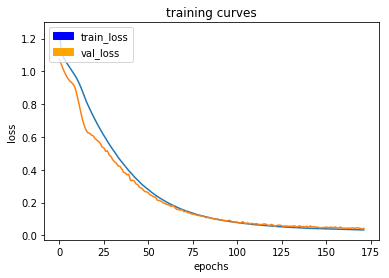

42/42 [==============================] - 62s - loss: 0.0334 - val_loss: 0.0432
Epoch 173/300
41/42 [============================>.] - ETA: 1s - loss: 0.0336

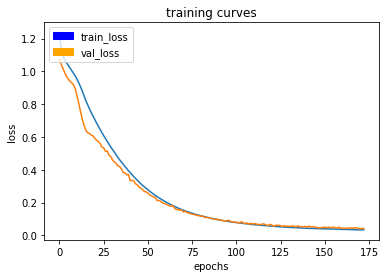

42/42 [==============================] - 62s - loss: 0.0335 - val_loss: 0.0412
Epoch 174/300
41/42 [============================>.] - ETA: 1s - loss: 0.0329

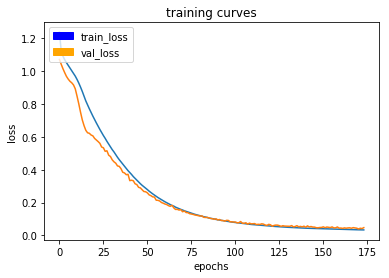

42/42 [==============================] - 62s - loss: 0.0330 - val_loss: 0.0467
Epoch 175/300
41/42 [============================>.] - ETA: 1s - loss: 0.0327

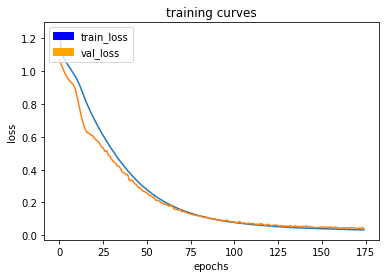

42/42 [==============================] - 62s - loss: 0.0326 - val_loss: 0.0417
Epoch 176/300
41/42 [============================>.] - ETA: 1s - loss: 0.0328

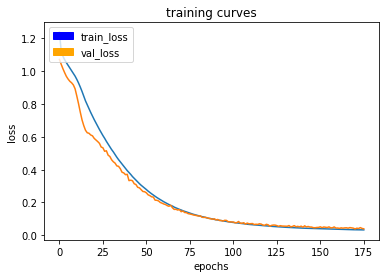

42/42 [==============================] - 62s - loss: 0.0329 - val_loss: 0.0394
Epoch 177/300
41/42 [============================>.] - ETA: 1s - loss: 0.0323

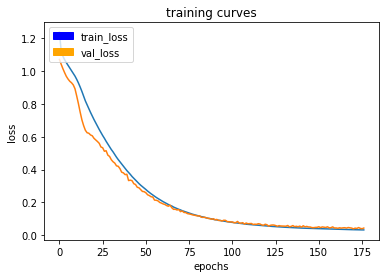

42/42 [==============================] - 61s - loss: 0.0323 - val_loss: 0.0436
Epoch 178/300
41/42 [============================>.] - ETA: 1s - loss: 0.0318

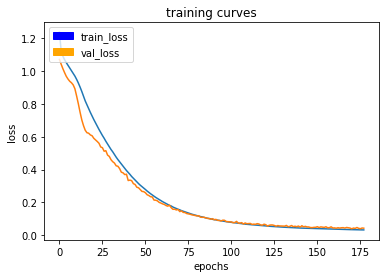

42/42 [==============================] - 61s - loss: 0.0323 - val_loss: 0.0425
Epoch 179/300
41/42 [============================>.] - ETA: 1s - loss: 0.0319

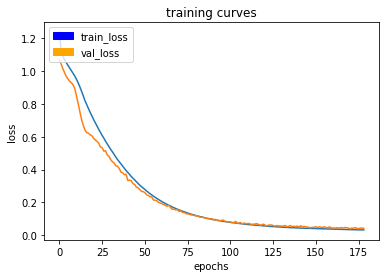

42/42 [==============================] - 61s - loss: 0.0320 - val_loss: 0.0413
Epoch 180/300
41/42 [============================>.] - ETA: 1s - loss: 0.0317

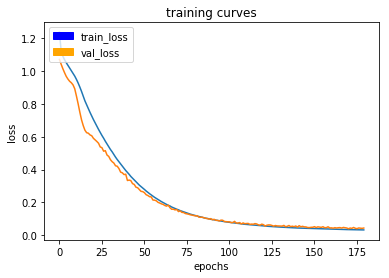

42/42 [==============================] - 62s - loss: 0.0317 - val_loss: 0.0432
Epoch 181/300
41/42 [============================>.] - ETA: 1s - loss: 0.0316

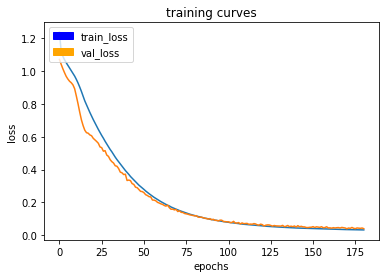

42/42 [==============================] - 62s - loss: 0.0316 - val_loss: 0.0394
Epoch 182/300
41/42 [============================>.] - ETA: 1s - loss: 0.0313

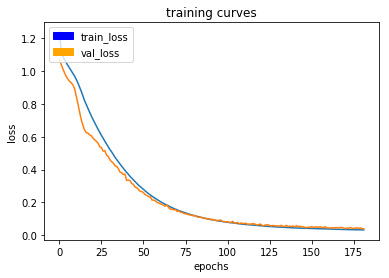

42/42 [==============================] - 62s - loss: 0.0314 - val_loss: 0.0377
Epoch 183/300
41/42 [============================>.] - ETA: 1s - loss: 0.0312

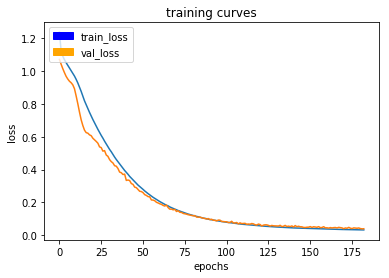

42/42 [==============================] - 62s - loss: 0.0311 - val_loss: 0.0384
Epoch 184/300
41/42 [============================>.] - ETA: 1s - loss: 0.0312

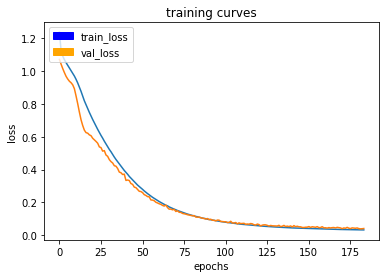

42/42 [==============================] - 62s - loss: 0.0311 - val_loss: 0.0398
Epoch 185/300
41/42 [============================>.] - ETA: 1s - loss: 0.0306

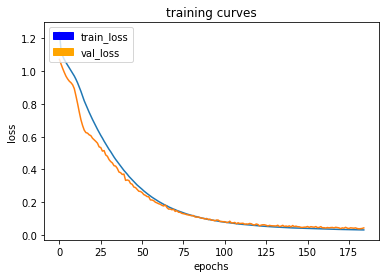

42/42 [==============================] - 62s - loss: 0.0312 - val_loss: 0.0431
Epoch 186/300
41/42 [============================>.] - ETA: 1s - loss: 0.0306

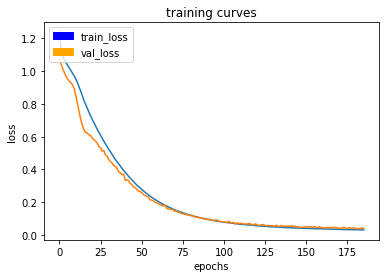

42/42 [==============================] - 62s - loss: 0.0305 - val_loss: 0.0398
Epoch 187/300
41/42 [============================>.] - ETA: 1s - loss: 0.0305

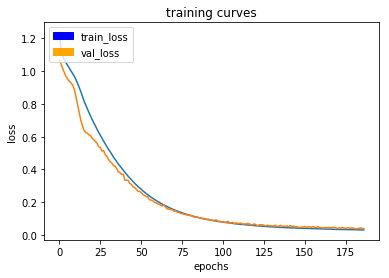

42/42 [==============================] - 61s - loss: 0.0304 - val_loss: 0.0380
Epoch 188/300
41/42 [============================>.] - ETA: 1s - loss: 0.0302

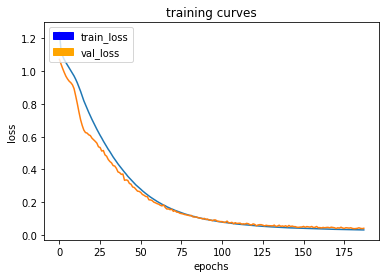

42/42 [==============================] - 62s - loss: 0.0301 - val_loss: 0.0401
Epoch 189/300
41/42 [============================>.] - ETA: 1s - loss: 0.0301

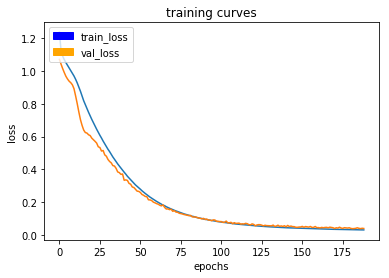

42/42 [==============================] - 62s - loss: 0.0300 - val_loss: 0.0387
Epoch 190/300
41/42 [============================>.] - ETA: 1s - loss: 0.0298

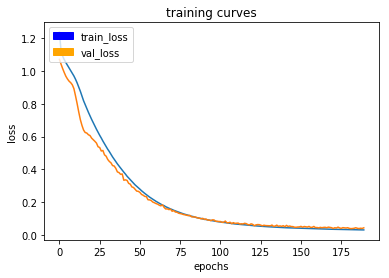

42/42 [==============================] - 62s - loss: 0.0297 - val_loss: 0.0426
Epoch 191/300
41/42 [============================>.] - ETA: 1s - loss: 0.0300

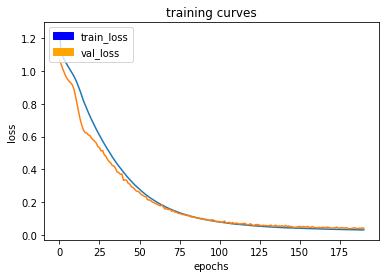

42/42 [==============================] - 62s - loss: 0.0300 - val_loss: 0.0394
Epoch 192/300
41/42 [============================>.] - ETA: 1s - loss: 0.0297

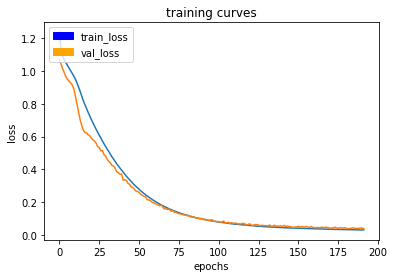

42/42 [==============================] - 62s - loss: 0.0297 - val_loss: 0.0390
Epoch 193/300
41/42 [============================>.] - ETA: 1s - loss: 0.0295

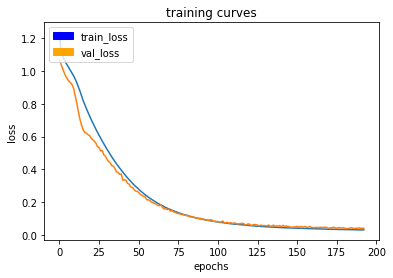

42/42 [==============================] - 61s - loss: 0.0294 - val_loss: 0.0398
Epoch 194/300
41/42 [============================>.] - ETA: 1s - loss: 0.0294

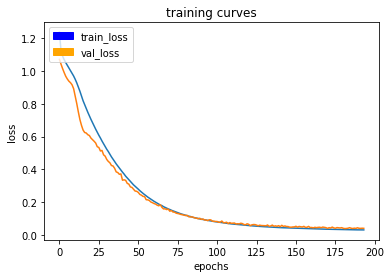

42/42 [==============================] - 62s - loss: 0.0294 - val_loss: 0.0391
Epoch 195/300
41/42 [============================>.] - ETA: 1s - loss: 0.0292

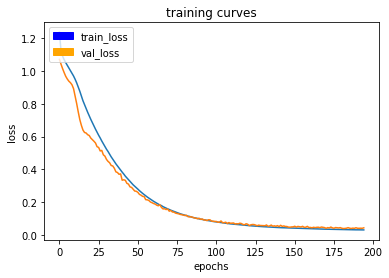

42/42 [==============================] - 61s - loss: 0.0292 - val_loss: 0.0420
Epoch 196/300
41/42 [============================>.] - ETA: 1s - loss: 0.0294

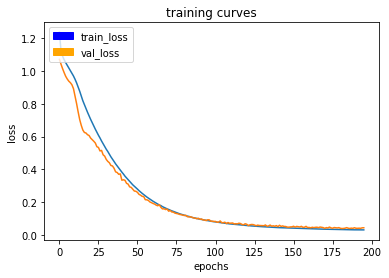

42/42 [==============================] - 62s - loss: 0.0294 - val_loss: 0.0424
Epoch 197/300
41/42 [============================>.] - ETA: 1s - loss: 0.0286

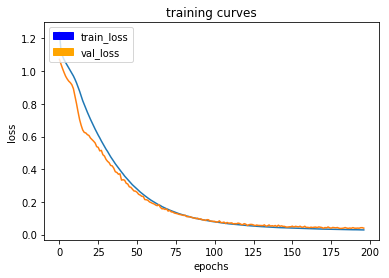

42/42 [==============================] - 62s - loss: 0.0286 - val_loss: 0.0394
Epoch 198/300
41/42 [============================>.] - ETA: 1s - loss: 0.0287

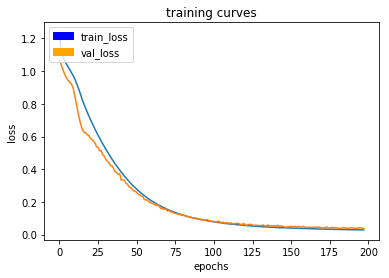

42/42 [==============================] - 61s - loss: 0.0287 - val_loss: 0.0375
Epoch 199/300
41/42 [============================>.] - ETA: 1s - loss: 0.0287

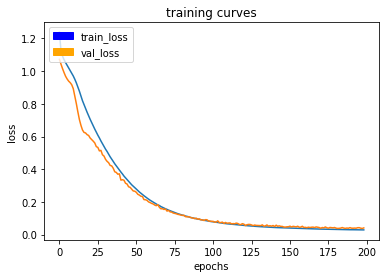

42/42 [==============================] - 62s - loss: 0.0287 - val_loss: 0.0409
Epoch 200/300
41/42 [============================>.] - ETA: 1s - loss: 0.0285

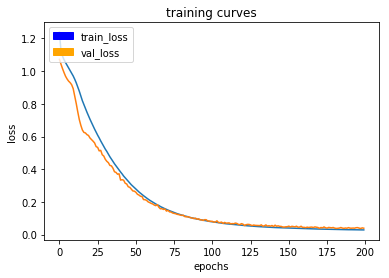

42/42 [==============================] - 61s - loss: 0.0285 - val_loss: 0.0389
Epoch 201/300
41/42 [============================>.] - ETA: 1s - loss: 0.0283

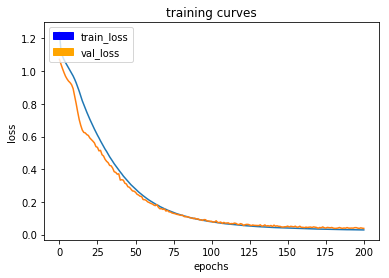

42/42 [==============================] - 62s - loss: 0.0284 - val_loss: 0.0376
Epoch 202/300
41/42 [============================>.] - ETA: 1s - loss: 0.0280

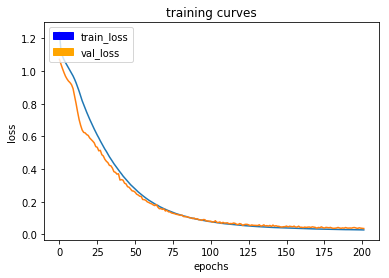

42/42 [==============================] - 62s - loss: 0.0280 - val_loss: 0.0366
Epoch 203/300
41/42 [============================>.] - ETA: 1s - loss: 0.0280

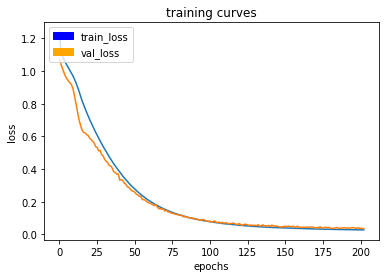

42/42 [==============================] - 61s - loss: 0.0279 - val_loss: 0.0364
Epoch 204/300
41/42 [============================>.] - ETA: 1s - loss: 0.0281

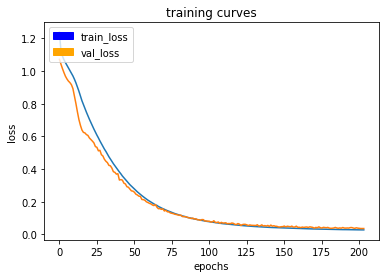

42/42 [==============================] - 61s - loss: 0.0281 - val_loss: 0.0365
Epoch 205/300
41/42 [============================>.] - ETA: 1s - loss: 0.0279

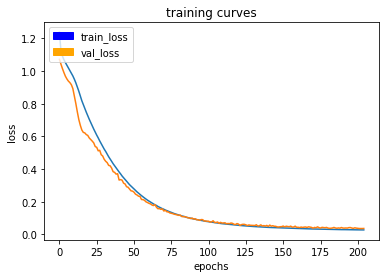

42/42 [==============================] - 61s - loss: 0.0280 - val_loss: 0.0369
Epoch 206/300
41/42 [============================>.] - ETA: 1s - loss: 0.0274

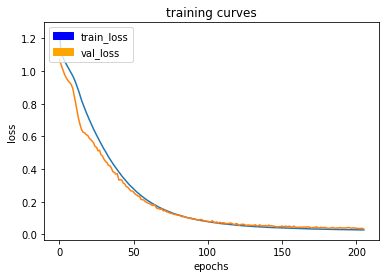

42/42 [==============================] - 62s - loss: 0.0279 - val_loss: 0.0324
Epoch 207/300
41/42 [============================>.] - ETA: 1s - loss: 0.0276

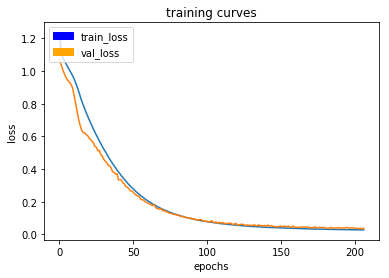

42/42 [==============================] - 62s - loss: 0.0275 - val_loss: 0.0383
Epoch 208/300
41/42 [============================>.] - ETA: 1s - loss: 0.0277

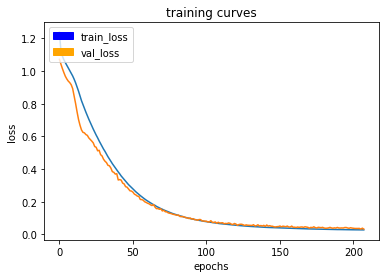

42/42 [==============================] - 62s - loss: 0.0279 - val_loss: 0.0325
Epoch 209/300
41/42 [============================>.] - ETA: 1s - loss: 0.0279

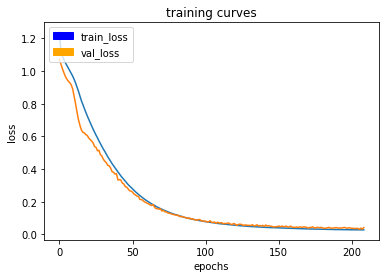

42/42 [==============================] - 61s - loss: 0.0278 - val_loss: 0.0413
Epoch 210/300
41/42 [============================>.] - ETA: 1s - loss: 0.0276

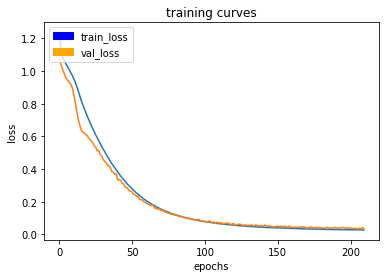

42/42 [==============================] - 61s - loss: 0.0277 - val_loss: 0.0381
Epoch 211/300
41/42 [============================>.] - ETA: 1s - loss: 0.0273

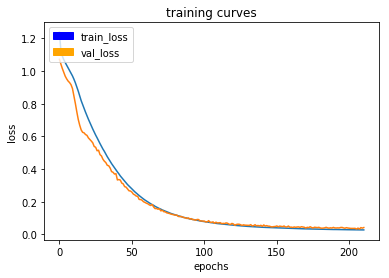

42/42 [==============================] - 62s - loss: 0.0271 - val_loss: 0.0417
Epoch 212/300
41/42 [============================>.] - ETA: 1s - loss: 0.0272

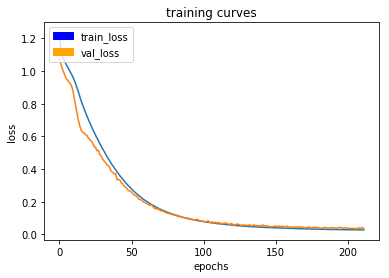

42/42 [==============================] - 62s - loss: 0.0271 - val_loss: 0.0359
Epoch 213/300
41/42 [============================>.] - ETA: 1s - loss: 0.0271

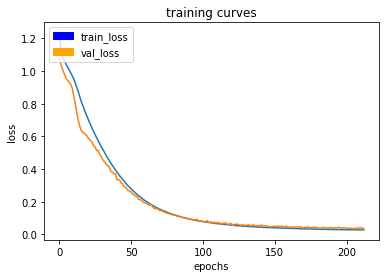

42/42 [==============================] - 62s - loss: 0.0269 - val_loss: 0.0366
Epoch 214/300
41/42 [============================>.] - ETA: 1s - loss: 0.0269

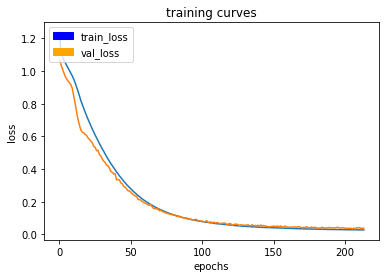

42/42 [==============================] - 62s - loss: 0.0270 - val_loss: 0.0381
Epoch 215/300
41/42 [============================>.] - ETA: 1s - loss: 0.0268

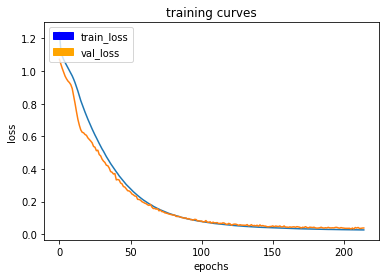

42/42 [==============================] - 62s - loss: 0.0268 - val_loss: 0.0386
Epoch 216/300
41/42 [============================>.] - ETA: 1s - loss: 0.0267

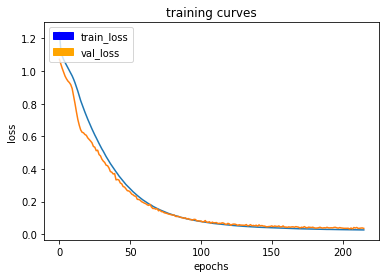

42/42 [==============================] - 62s - loss: 0.0266 - val_loss: 0.0361
Epoch 217/300
41/42 [============================>.] - ETA: 1s - loss: 0.0266

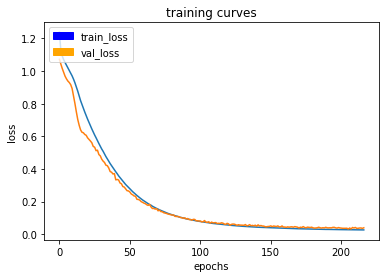

42/42 [==============================] - 62s - loss: 0.0265 - val_loss: 0.0396
Epoch 218/300
41/42 [============================>.] - ETA: 1s - loss: 0.0265

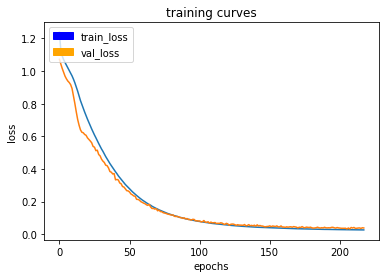

42/42 [==============================] - 62s - loss: 0.0265 - val_loss: 0.0384
Epoch 219/300
41/42 [============================>.] - ETA: 1s - loss: 0.0265

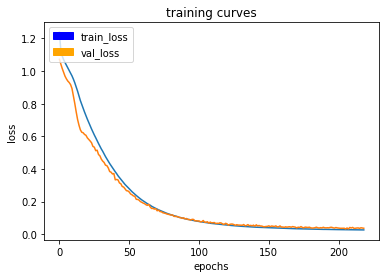

42/42 [==============================] - 62s - loss: 0.0263 - val_loss: 0.0366
Epoch 220/300
41/42 [============================>.] - ETA: 1s - loss: 0.0262

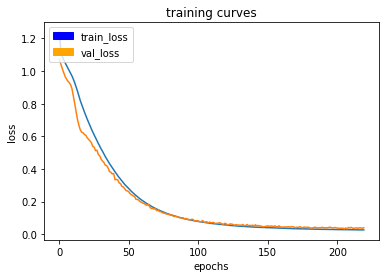

42/42 [==============================] - 62s - loss: 0.0262 - val_loss: 0.0395
Epoch 221/300
41/42 [============================>.] - ETA: 1s - loss: 0.0259

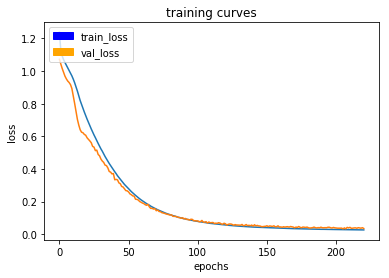

42/42 [==============================] - 61s - loss: 0.0259 - val_loss: 0.0348
Epoch 222/300
41/42 [============================>.] - ETA: 1s - loss: 0.0259

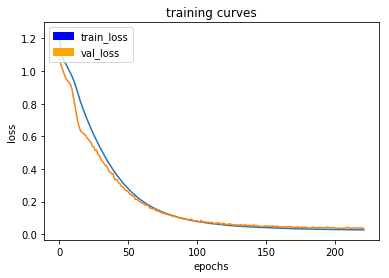

42/42 [==============================] - 62s - loss: 0.0258 - val_loss: 0.0349
Epoch 223/300
41/42 [============================>.] - ETA: 1s - loss: 0.0267

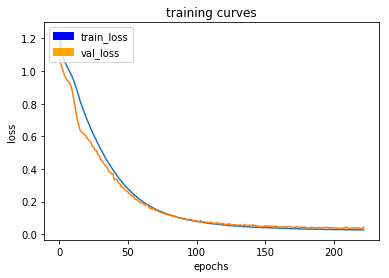

42/42 [==============================] - 61s - loss: 0.0266 - val_loss: 0.0422
Epoch 224/300
41/42 [============================>.] - ETA: 1s - loss: 0.0262

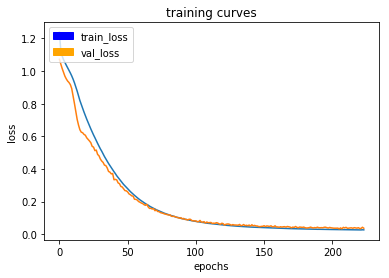

42/42 [==============================] - 61s - loss: 0.0261 - val_loss: 0.0362
Epoch 225/300
41/42 [============================>.] - ETA: 1s - loss: 0.0256

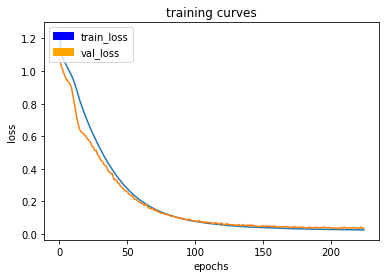

42/42 [==============================] - 61s - loss: 0.0256 - val_loss: 0.0351
Epoch 226/300
41/42 [============================>.] - ETA: 1s - loss: 0.0256

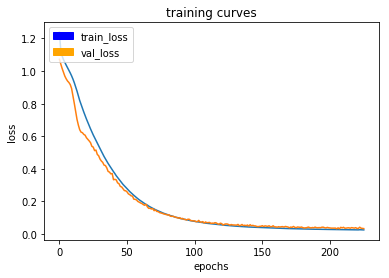

42/42 [==============================] - 61s - loss: 0.0256 - val_loss: 0.0337
Epoch 227/300
41/42 [============================>.] - ETA: 1s - loss: 0.0257

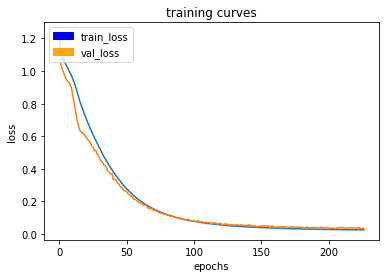

42/42 [==============================] - 62s - loss: 0.0257 - val_loss: 0.0358
Epoch 228/300
41/42 [============================>.] - ETA: 1s - loss: 0.0254

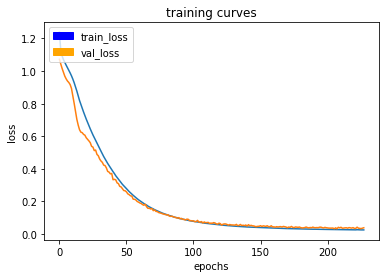

42/42 [==============================] - 62s - loss: 0.0254 - val_loss: 0.0386
Epoch 229/300
41/42 [============================>.] - ETA: 1s - loss: 0.0252

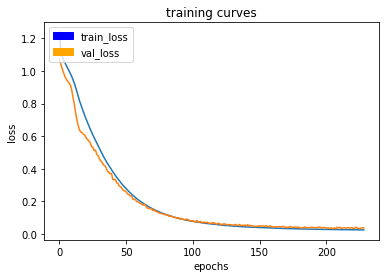

42/42 [==============================] - 62s - loss: 0.0254 - val_loss: 0.0370
Epoch 230/300
41/42 [============================>.] - ETA: 1s - loss: 0.0253

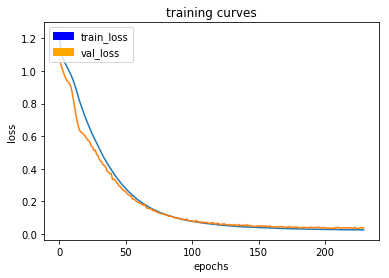

42/42 [==============================] - 62s - loss: 0.0252 - val_loss: 0.0388
Epoch 231/300
41/42 [============================>.] - ETA: 1s - loss: 0.0252

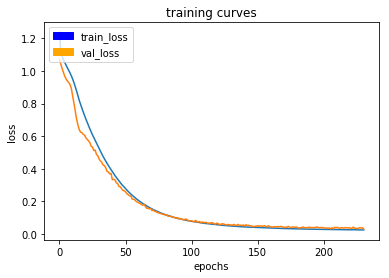

42/42 [==============================] - 62s - loss: 0.0252 - val_loss: 0.0295
Epoch 232/300
41/42 [============================>.] - ETA: 1s - loss: 0.0252

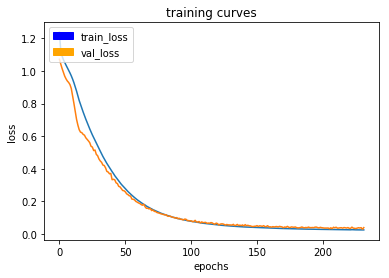

42/42 [==============================] - 61s - loss: 0.0251 - val_loss: 0.0392
Epoch 233/300
41/42 [============================>.] - ETA: 1s - loss: 0.0251

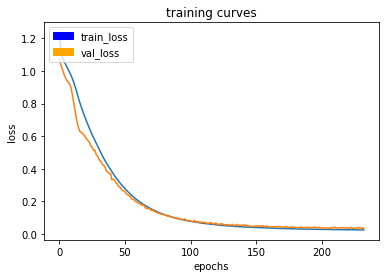

42/42 [==============================] - 62s - loss: 0.0251 - val_loss: 0.0342
Epoch 234/300
41/42 [============================>.] - ETA: 1s - loss: 0.0248

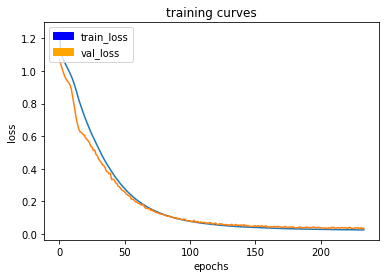

42/42 [==============================] - 62s - loss: 0.0254 - val_loss: 0.0355
Epoch 235/300
41/42 [============================>.] - ETA: 1s - loss: 0.0251

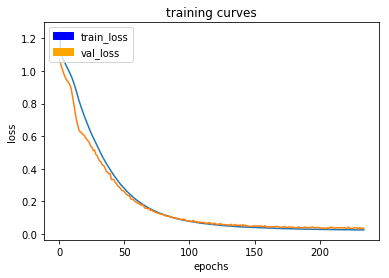

42/42 [==============================] - 62s - loss: 0.0250 - val_loss: 0.0360
Epoch 236/300
41/42 [============================>.] - ETA: 1s - loss: 0.0249

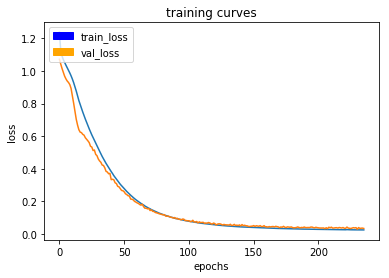

42/42 [==============================] - 62s - loss: 0.0248 - val_loss: 0.0338
Epoch 237/300
41/42 [============================>.] - ETA: 1s - loss: 0.0247

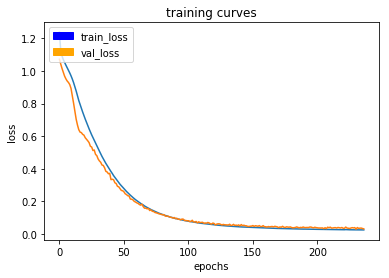

42/42 [==============================] - 62s - loss: 0.0246 - val_loss: 0.0310
Epoch 238/300
41/42 [============================>.] - ETA: 1s - loss: 0.0245

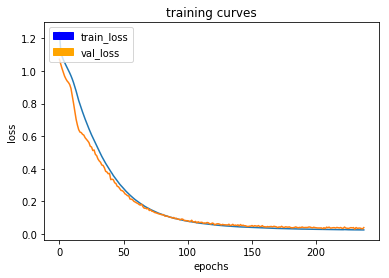

42/42 [==============================] - 62s - loss: 0.0247 - val_loss: 0.0386
Epoch 239/300
41/42 [============================>.] - ETA: 1s - loss: 0.0249

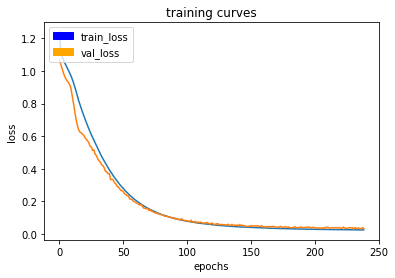

42/42 [==============================] - 61s - loss: 0.0248 - val_loss: 0.0341
Epoch 240/300
41/42 [============================>.] - ETA: 1s - loss: 0.0246

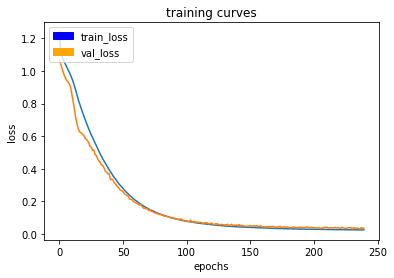

42/42 [==============================] - 62s - loss: 0.0247 - val_loss: 0.0353
Epoch 241/300
41/42 [============================>.] - ETA: 1s - loss: 0.0244

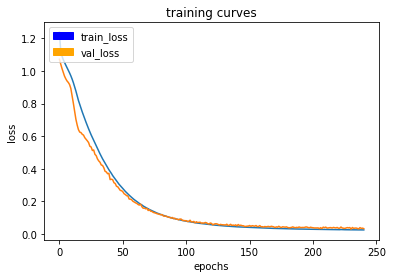

42/42 [==============================] - 61s - loss: 0.0245 - val_loss: 0.0324
Epoch 242/300
41/42 [============================>.] - ETA: 1s - loss: 0.0243

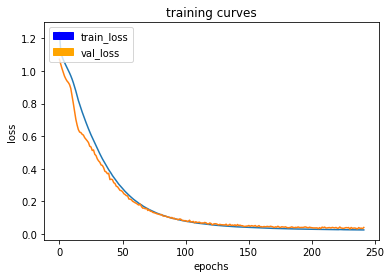

42/42 [==============================] - 62s - loss: 0.0242 - val_loss: 0.0392
Epoch 243/300
41/42 [============================>.] - ETA: 1s - loss: 0.0244

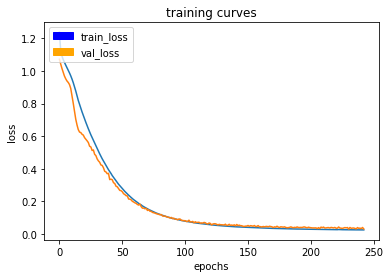

42/42 [==============================] - 62s - loss: 0.0244 - val_loss: 0.0302
Epoch 244/300
41/42 [============================>.] - ETA: 1s - loss: 0.0242

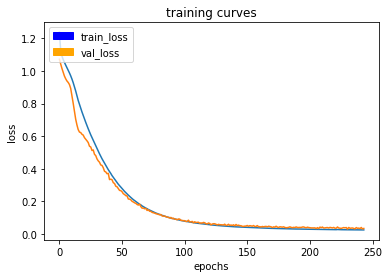

42/42 [==============================] - 62s - loss: 0.0242 - val_loss: 0.0333
Epoch 245/300
41/42 [============================>.] - ETA: 1s - loss: 0.0246

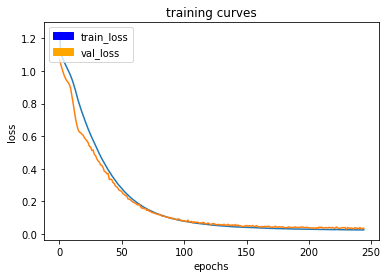

42/42 [==============================] - 62s - loss: 0.0246 - val_loss: 0.0342
Epoch 246/300
41/42 [============================>.] - ETA: 1s - loss: 0.0242

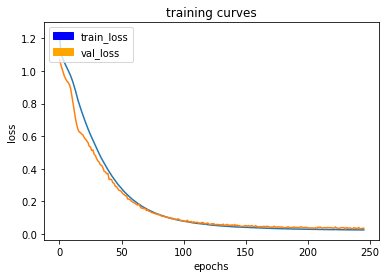

42/42 [==============================] - 62s - loss: 0.0242 - val_loss: 0.0339
Epoch 247/300
41/42 [============================>.] - ETA: 1s - loss: 0.0240

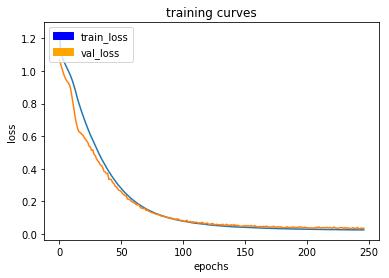

42/42 [==============================] - 62s - loss: 0.0240 - val_loss: 0.0345
Epoch 248/300
41/42 [============================>.] - ETA: 1s - loss: 0.0239

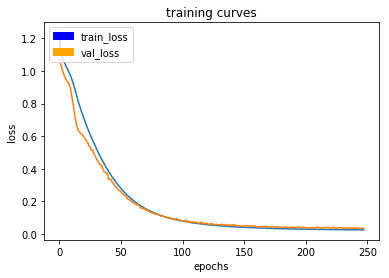

42/42 [==============================] - 61s - loss: 0.0239 - val_loss: 0.0333
Epoch 249/300
41/42 [============================>.] - ETA: 1s - loss: 0.0239

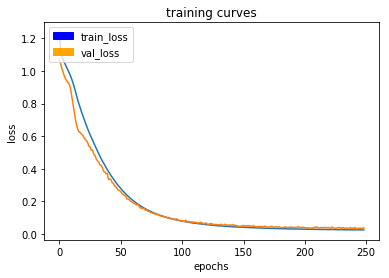

42/42 [==============================] - 62s - loss: 0.0239 - val_loss: 0.0371
Epoch 250/300
41/42 [============================>.] - ETA: 1s - loss: 0.0236

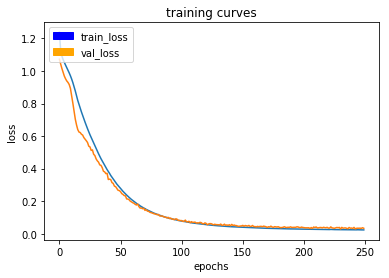

42/42 [==============================] - 61s - loss: 0.0237 - val_loss: 0.0334
Epoch 251/300
41/42 [============================>.] - ETA: 1s - loss: 0.0238

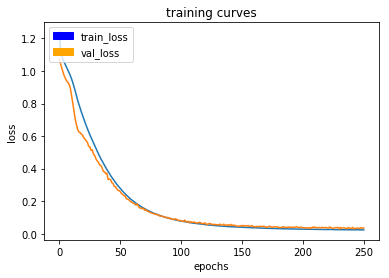

42/42 [==============================] - 62s - loss: 0.0239 - val_loss: 0.0363
Epoch 252/300
41/42 [============================>.] - ETA: 1s - loss: 0.0240

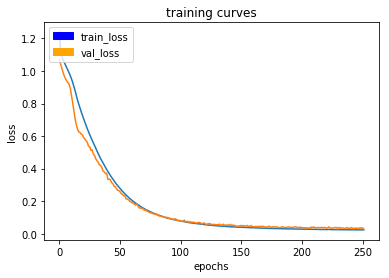

42/42 [==============================] - 62s - loss: 0.0240 - val_loss: 0.0287
Epoch 253/300
41/42 [============================>.] - ETA: 1s - loss: 0.0237

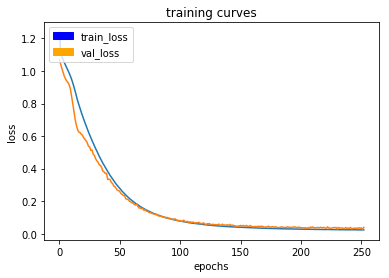

42/42 [==============================] - 62s - loss: 0.0237 - val_loss: 0.0391
Epoch 254/300
41/42 [============================>.] - ETA: 1s - loss: 0.0235

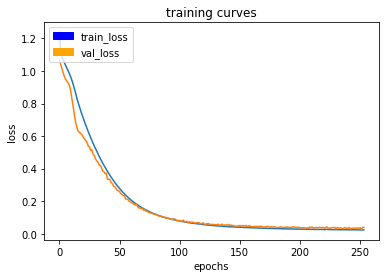

42/42 [==============================] - 62s - loss: 0.0236 - val_loss: 0.0391
Epoch 255/300
41/42 [============================>.] - ETA: 1s - loss: 0.0234

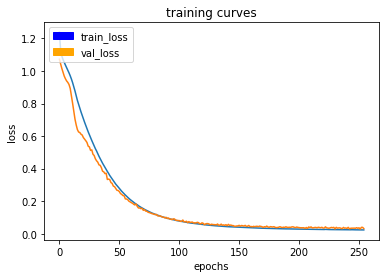

42/42 [==============================] - 61s - loss: 0.0233 - val_loss: 0.0320
Epoch 256/300
41/42 [============================>.] - ETA: 1s - loss: 0.0237

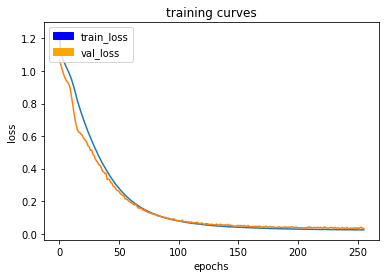

42/42 [==============================] - 61s - loss: 0.0237 - val_loss: 0.0327
Epoch 257/300
41/42 [============================>.] - ETA: 1s - loss: 0.0233

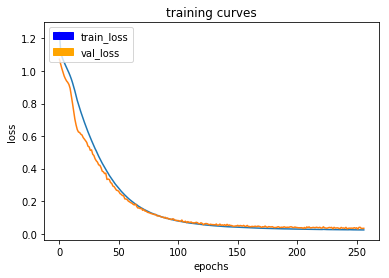

42/42 [==============================] - 62s - loss: 0.0233 - val_loss: 0.0332
Epoch 258/300
41/42 [============================>.] - ETA: 1s - loss: 0.0233

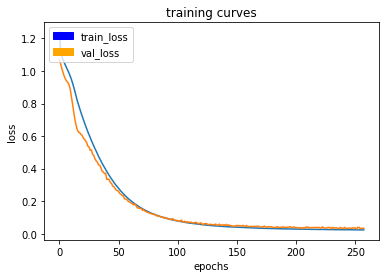

42/42 [==============================] - 61s - loss: 0.0234 - val_loss: 0.0335
Epoch 259/300
41/42 [============================>.] - ETA: 1s - loss: 0.0232

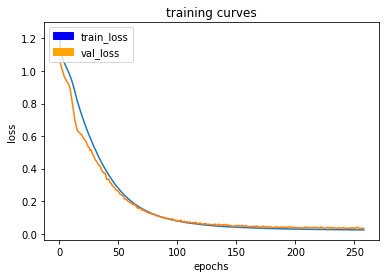

42/42 [==============================] - 62s - loss: 0.0231 - val_loss: 0.0337
Epoch 260/300
41/42 [============================>.] - ETA: 1s - loss: 0.0233

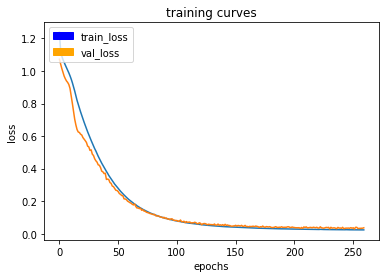

42/42 [==============================] - 62s - loss: 0.0234 - val_loss: 0.0362
Epoch 261/300
41/42 [============================>.] - ETA: 1s - loss: 0.0230

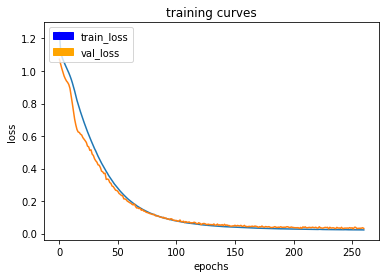

42/42 [==============================] - 62s - loss: 0.0230 - val_loss: 0.0323
Epoch 262/300
41/42 [============================>.] - ETA: 1s - loss: 0.0228

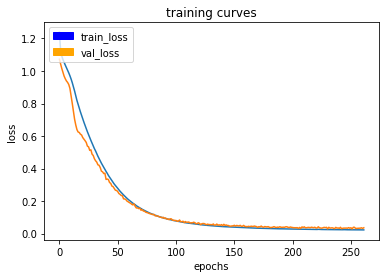

42/42 [==============================] - 61s - loss: 0.0236 - val_loss: 0.0362
Epoch 263/300
41/42 [============================>.] - ETA: 1s - loss: 0.0237

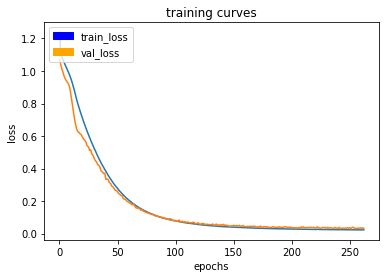

42/42 [==============================] - 61s - loss: 0.0237 - val_loss: 0.0326
Epoch 264/300
41/42 [============================>.] - ETA: 1s - loss: 0.0230

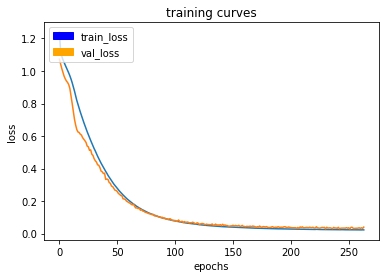

42/42 [==============================] - 61s - loss: 0.0231 - val_loss: 0.0403
Epoch 265/300
41/42 [============================>.] - ETA: 1s - loss: 0.0231

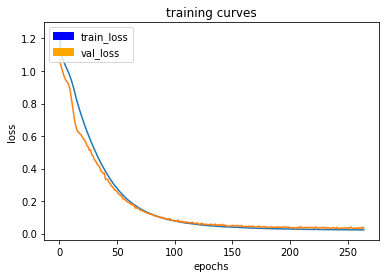

42/42 [==============================] - 62s - loss: 0.0232 - val_loss: 0.0335
Epoch 266/300
41/42 [============================>.] - ETA: 1s - loss: 0.0227

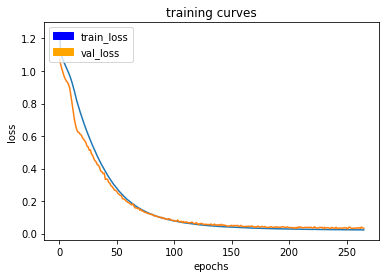

42/42 [==============================] - 62s - loss: 0.0229 - val_loss: 0.0333
Epoch 267/300
41/42 [============================>.] - ETA: 1s - loss: 0.0231

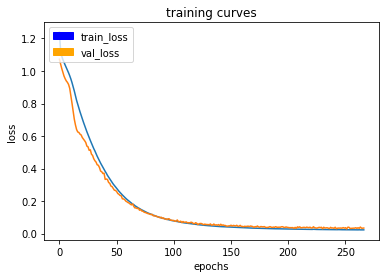

42/42 [==============================] - 62s - loss: 0.0231 - val_loss: 0.0343
Epoch 268/300
41/42 [============================>.] - ETA: 1s - loss: 0.0227

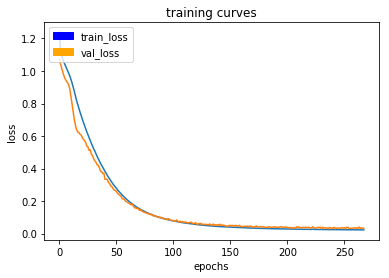

42/42 [==============================] - 61s - loss: 0.0227 - val_loss: 0.0333
Epoch 269/300
41/42 [============================>.] - ETA: 1s - loss: 0.0226

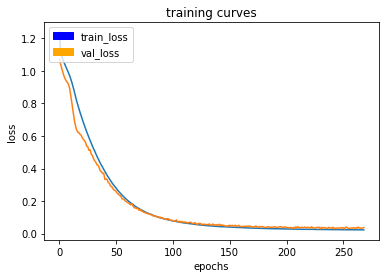

42/42 [==============================] - 61s - loss: 0.0225 - val_loss: 0.0370
Epoch 270/300
41/42 [============================>.] - ETA: 1s - loss: 0.0228

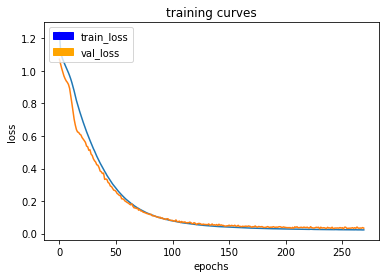

42/42 [==============================] - 61s - loss: 0.0229 - val_loss: 0.0332
Epoch 271/300
41/42 [============================>.] - ETA: 1s - loss: 0.0228

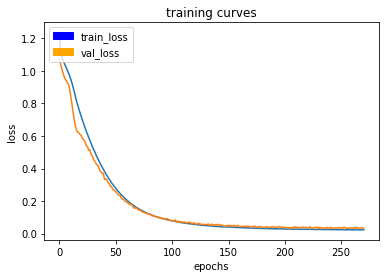

42/42 [==============================] - 62s - loss: 0.0228 - val_loss: 0.0332
Epoch 272/300
41/42 [============================>.] - ETA: 1s - loss: 0.0225

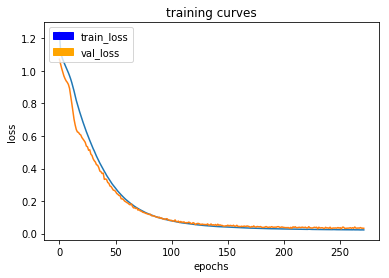

42/42 [==============================] - 62s - loss: 0.0225 - val_loss: 0.0325
Epoch 273/300
41/42 [============================>.] - ETA: 1s - loss: 0.0225

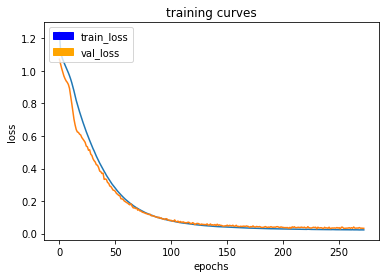

42/42 [==============================] - 61s - loss: 0.0229 - val_loss: 0.0323
Epoch 274/300
41/42 [============================>.] - ETA: 1s - loss: 0.0223

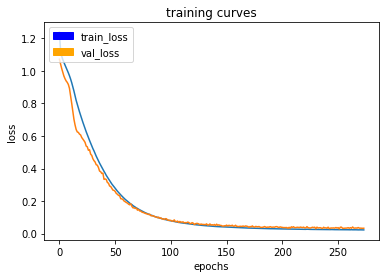

42/42 [==============================] - 62s - loss: 0.0223 - val_loss: 0.0327
Epoch 275/300
41/42 [============================>.] - ETA: 1s - loss: 0.0223

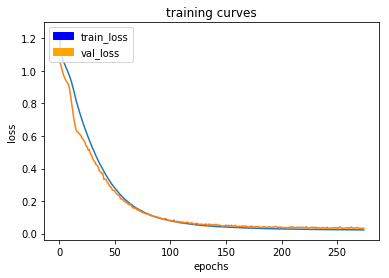

42/42 [==============================] - 62s - loss: 0.0222 - val_loss: 0.0335
Epoch 276/300
41/42 [============================>.] - ETA: 1s - loss: 0.0224

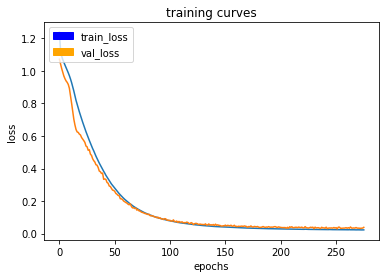

42/42 [==============================] - 61s - loss: 0.0225 - val_loss: 0.0380
Epoch 277/300
41/42 [============================>.] - ETA: 1s - loss: 0.0223

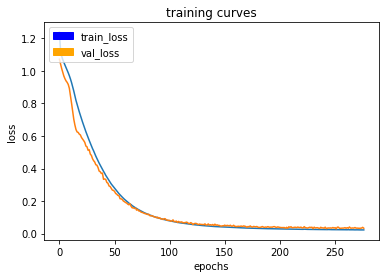

42/42 [==============================] - 61s - loss: 0.0224 - val_loss: 0.0326
Epoch 278/300
41/42 [============================>.] - ETA: 1s - loss: 0.0222

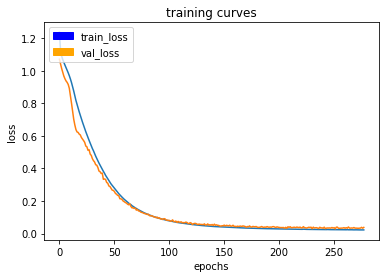

42/42 [==============================] - 61s - loss: 0.0222 - val_loss: 0.0376
Epoch 279/300
41/42 [============================>.] - ETA: 1s - loss: 0.0222

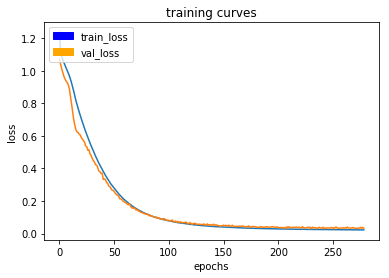

42/42 [==============================] - 61s - loss: 0.0226 - val_loss: 0.0326
Epoch 280/300
41/42 [============================>.] - ETA: 1s - loss: 0.0221

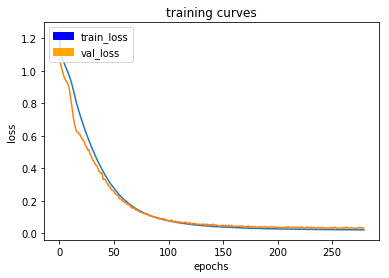

42/42 [==============================] - 62s - loss: 0.0220 - val_loss: 0.0323
Epoch 281/300
41/42 [============================>.] - ETA: 1s - loss: 0.0223

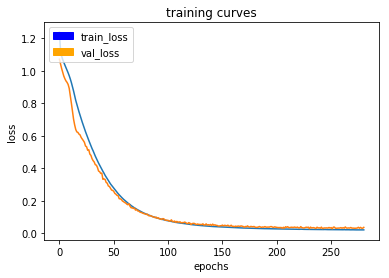

42/42 [==============================] - 62s - loss: 0.0223 - val_loss: 0.0377
Epoch 282/300
41/42 [============================>.] - ETA: 1s - loss: 0.0219

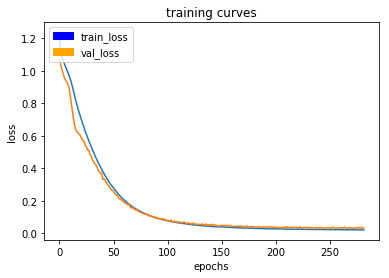

42/42 [==============================] - 62s - loss: 0.0223 - val_loss: 0.0321
Epoch 283/300
41/42 [============================>.] - ETA: 1s - loss: 0.0224

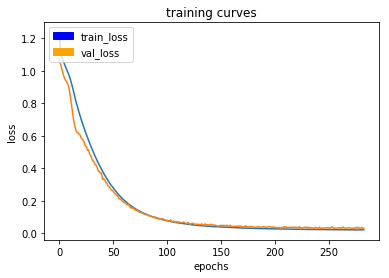

42/42 [==============================] - 61s - loss: 0.0224 - val_loss: 0.0326
Epoch 284/300
41/42 [============================>.] - ETA: 1s - loss: 0.0220

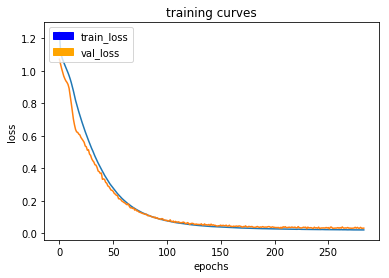

42/42 [==============================] - 62s - loss: 0.0220 - val_loss: 0.0330
Epoch 285/300
41/42 [============================>.] - ETA: 1s - loss: 0.0218

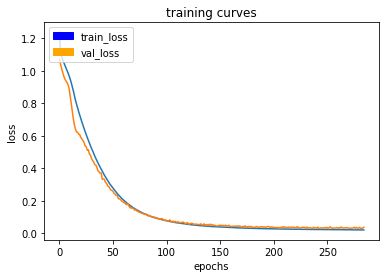

42/42 [==============================] - 61s - loss: 0.0218 - val_loss: 0.0384
Epoch 286/300
41/42 [============================>.] - ETA: 1s - loss: 0.0219

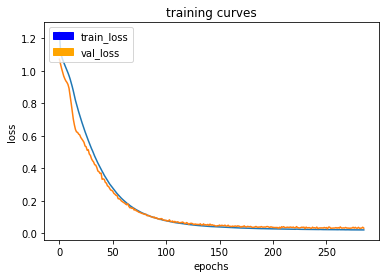

42/42 [==============================] - 62s - loss: 0.0219 - val_loss: 0.0327
Epoch 287/300
41/42 [============================>.] - ETA: 1s - loss: 0.0218

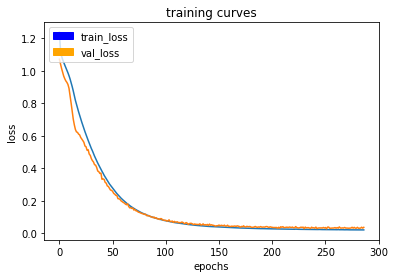

42/42 [==============================] - 61s - loss: 0.0221 - val_loss: 0.0376
Epoch 288/300
41/42 [============================>.] - ETA: 1s - loss: 0.0215

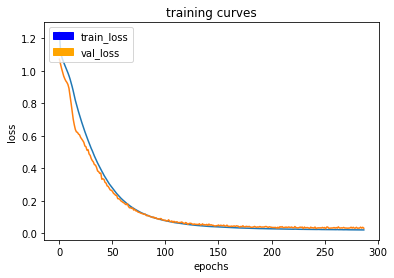

42/42 [==============================] - 62s - loss: 0.0216 - val_loss: 0.0320
Epoch 289/300
41/42 [============================>.] - ETA: 1s - loss: 0.0216

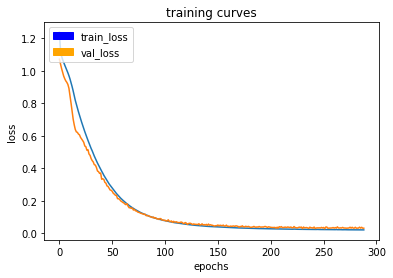

42/42 [==============================] - 61s - loss: 0.0218 - val_loss: 0.0322
Epoch 290/300
41/42 [============================>.] - ETA: 1s - loss: 0.0216

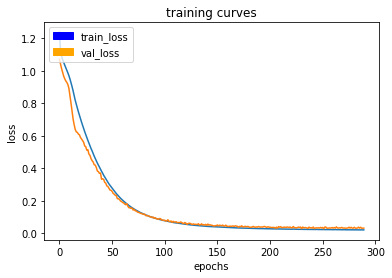

42/42 [==============================] - 62s - loss: 0.0218 - val_loss: 0.0326
Epoch 291/300
41/42 [============================>.] - ETA: 1s - loss: 0.0215

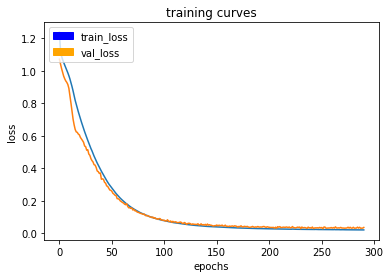

42/42 [==============================] - 61s - loss: 0.0215 - val_loss: 0.0366
Epoch 292/300
41/42 [============================>.] - ETA: 1s - loss: 0.0218

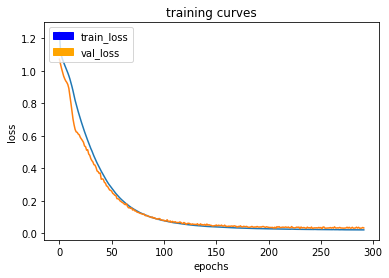

42/42 [==============================] - 62s - loss: 0.0218 - val_loss: 0.0334
Epoch 293/300
41/42 [============================>.] - ETA: 1s - loss: 0.0217

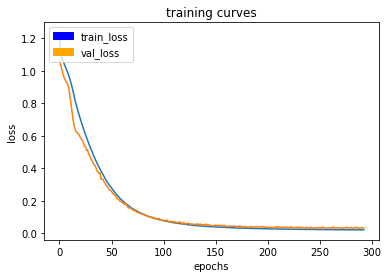

42/42 [==============================] - 62s - loss: 0.0216 - val_loss: 0.0328
Epoch 294/300
41/42 [============================>.] - ETA: 1s - loss: 0.0216

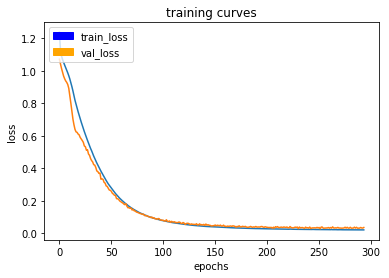

42/42 [==============================] - 62s - loss: 0.0216 - val_loss: 0.0364
Epoch 295/300
41/42 [============================>.] - ETA: 1s - loss: 0.0212

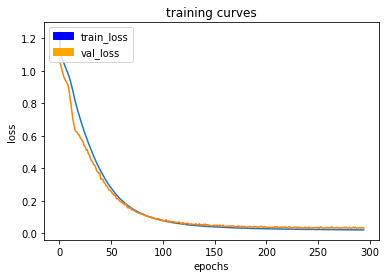

42/42 [==============================] - 62s - loss: 0.0211 - val_loss: 0.0326
Epoch 296/300
41/42 [============================>.] - ETA: 1s - loss: 0.0213

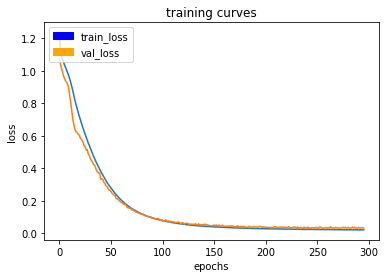

42/42 [==============================] - 62s - loss: 0.0212 - val_loss: 0.0328
Epoch 297/300
41/42 [============================>.] - ETA: 1s - loss: 0.0214

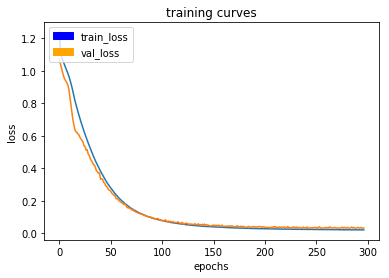

42/42 [==============================] - 61s - loss: 0.0213 - val_loss: 0.0321
Epoch 298/300
41/42 [============================>.] - ETA: 1s - loss: 0.0213

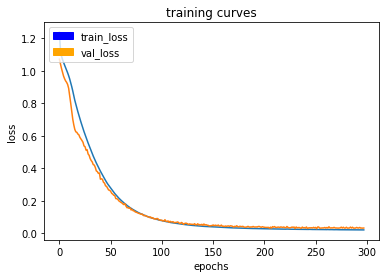

42/42 [==============================] - 62s - loss: 0.0212 - val_loss: 0.0329
Epoch 299/300
41/42 [============================>.] - ETA: 1s - loss: 0.0213

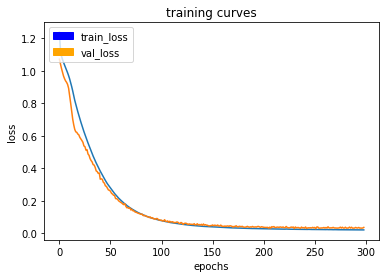

42/42 [==============================] - 61s - loss: 0.0212 - val_loss: 0.0366
Epoch 300/300
41/42 [============================>.] - ETA: 1s - loss: 0.0212

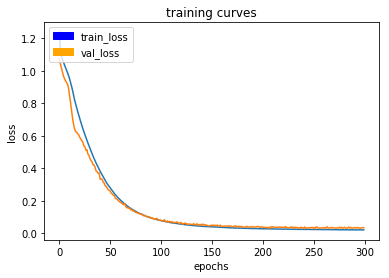

42/42 [==============================] - 62s - loss: 0.0214 - val_loss: 0.0341


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)
model.summary()

#keras.plot_model(model, to_file='model.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 20, 128)       512       
__________

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

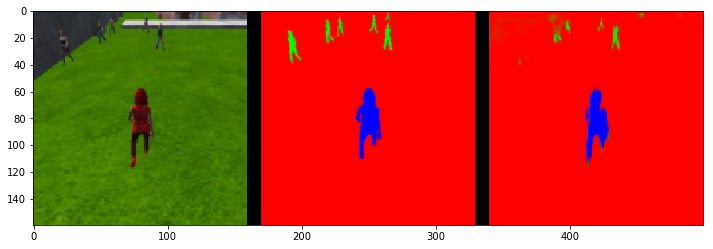

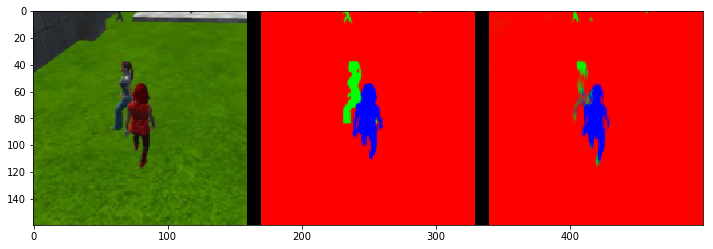

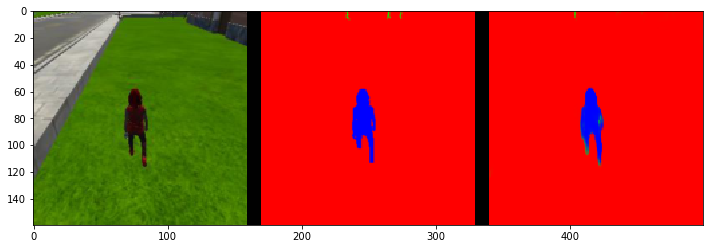

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

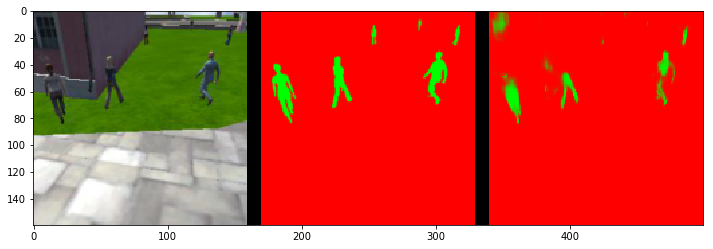

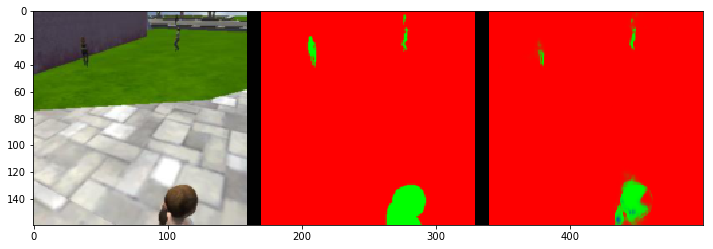

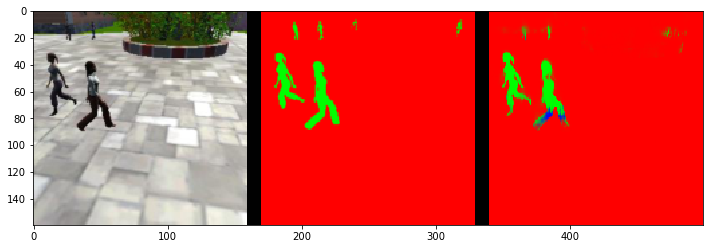

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

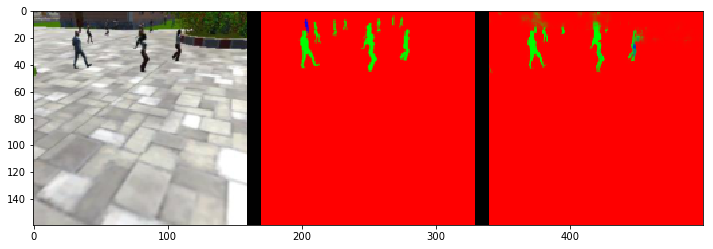

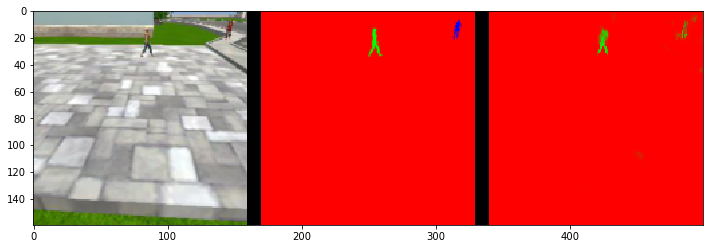

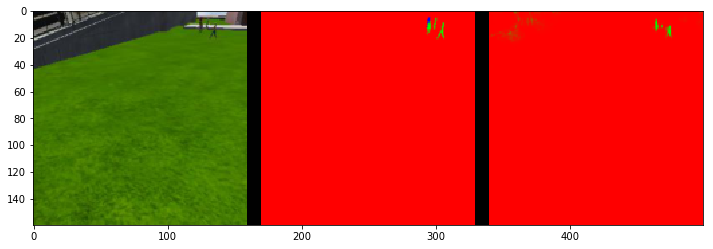

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9933169077910381
average intersection over union for other people is 0.258217072171184
average intersection over union for the hero is 0.8566296148650255
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9815882882051279
average intersection over union for other people is 0.6277627977556528
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 47, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9949909977484547
average intersection over union for other people is 0.3424388935413446
average intersection over union for the hero is 0.09949378912497162
number true positives: 79, number false positives: 2, number false negatives: 222


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6951631046119235


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.478061701995


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.332330856955
